# Explore sample-level QC results

In this notebook we further explore the sample-level QC results generated by [Sample-Level-QC.Rmd](https://github.com/verilylifesciences/variant-qc/blob/master/R/Sample-Level-QC.Rmd) and specifically take a closer look at the outliers.

<div class='alert alert-block alert-info'>
<b>How to use this notebook:</b><p>
    
<a href="https://github.com/verilylifesciences/variant-qc/blob/master/R/Sample-Level-QC.Rmd">RMarkdown</a> was used to run a particular set of analyses and generate a canned report. If you have questions about the details of the analyses, see the canned reports for details. This notebook reads in those previously computed results, and re-renders 'small multiples' of the results.<p>
    
With this notebook, specifically you can:<ul>    
        <li>modify the plots further
        <li>add new plots
        <li>change the QC cutoff thresholds when examining outliers
        <li>use updated sample information
        <li>use more features from the sample information
    </ul><p>

It is currently configured to read in the <a href="https://console.cloud.google.com/storage/genomics-public-data/simons-genome-diversity-project/reports">QC results</a> for the <a href="https://cloud.google.com/genomics/docs/public-datasets/simons">Simons Genome Diversity Project</a> data. You can modify it to instead read in results for <a href="https://console.cloud.google.com/storage/genomics-public-data/platinum-genomes/reports">DeepVariant Platinum Genomes</a>, <a href="https://console.cloud.google.com/storage/genomics-public-data/1000-genomes-phase-3/reports">1000 Genomes</a>, or results from your own cohort.
</div>

# Setup 

In [1]:
lapply(c('devtools', 'tidyverse', 'bigrquery', 'scales', 'skimr'),
       function(pkg_name) { if(! pkg_name %in% installed.packages()) { install.packages(pkg_name)} } )

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

In [2]:
library(bigrquery)
library(scales)
library(skimr)
library(tidyverse)


Attaching package: ‘skimr’

The following object is masked from ‘package:stats’:

    filter

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks skimr::filter(), stats::filter()
✖ dplyr::lag()        masks stats::lag()


In [3]:
#-----------[ CHANGE THIS] ------------------
BILLING_PROJECT_ID <- 'YOUR-PROJECT-ID'

In [4]:
AUTOSOMES <- c(paste('chr', c(as.character(seq(1, 22))), sep = ''),
               as.character(seq(1, 22)))
ALLOSOMES <- c('chrX', 'X', 'chrY', 'Y')
MITOCHONDRIA <- c('chrM', 'M', 'MT')

In [5]:
DEFAULT_PLOT_HEIGHT <- 7.5
options(repr.plot.width = 16, repr.plot.height = DEFAULT_PLOT_HEIGHT)
theme_set(theme_bw(base_size = 16))
update_geom_defaults('point', list(size = 2))

#' Returns a data frame with a y position and a label, for use annotating ggplot boxplots.
#'
#' @param d A data frame.
#' @return A data frame with column y as max and column label as length.
#'
get_boxplot_fun_data <- function(d) {
  return(data.frame(y = max(d), label = stringr::str_c('N = ', length(d))))
}

## Retrieve sample information

In [6]:
raw_sample_info <- bq_table_download(bq_project_query(BILLING_PROJECT_ID, '
SELECT
  id_from_vcf,
  sex,
  region
FROM
  `bigquery-public-data.human_genome_variants.simons_genome_diversity_project_sample_attributes`
'))

print(skim(raw_sample_info))

Skim summary statistics
 n obs: 279 
 n variables: 3 

── Variable type:character ─────────────────────────────────────────────────────
    variable missing complete   n min max empty n_unique
 id_from_vcf       0      279 279   9  17     0      279
      region       0      279 279   6  18     0        7
         sex      31      248 279   1   6     0        3


Wrangle this into the columns we expect for the rest of the notebook.

Note that some cohorts have samples from several different sequencing platforms such as Illumina HiSeq2000 or Illumina HiSeqX or Complete Genomics, so many plots are faceted by sequencing platform.

In [7]:
sample_info <- raw_sample_info %>%
    mutate(sequencing_platform = 'Illumina') %>%
    select(name = id_from_vcf, sequencing_platform, sex, ancestry = region)

dim(sample_info)

[1] 279   4

## Retrieve previously computed results

In [8]:
genome_results <- read_csv(pipe(
    'gsutil cat gs://genomics-public-data/simons-genome-diversity-project/reports/Simons_Genome_Diversity_Project_sample_results.csv'))
genome_results <- genome_results[,!grepl('X1', colnames(genome_results))]  # Drop row name column, if present.

print(skim(genome_results))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  name = col_character(),
  no_calls = col_double(),
  all_calls = col_double(),
  missingness_rate = col_double(),
  private_variant_count = col_double(),
  heterozygous_variant_count = col_double(),
  perct_het_alt_in_snvs = col_double(),
  perct_hom_alt_in_snvs = col_double(),
  hom_AA_count = col_double(),
  het_RA_count = col_double()
)


Skim summary statistics
 n obs: 279 
 n variables: 10 

── Variable type:character ─────────────────────────────────────────────────────
 variable missing complete   n min max empty n_unique
     name       0      279 279   9  17     0      279

── Variable type:numeric ───────────────────────────────────────────────────────
                   variable missing complete   n       mean         sd
                  all_calls       0      279 279 4202064.38 347527.07 
               het_RA_count       2      277 279   15557     20910.59 
 heterozygous_variant_count       2      277 279 1538217.88 240758.45 
               hom_AA_count       2      277 279   44883.25  15131.25 
           missingness_rate       0      279 279       0.13      0.015
                   no_calls       0      279 279  566696.65  78680.61 
      perct_het_alt_in_snvs       2      277 279       0.21      0.27 
      perct_hom_alt_in_snvs       2      277 279       0.79      0.27 
      private_variant_count       

In [9]:
chrom_results <- read_csv(pipe(
    'gsutil cat gs://genomics-public-data/simons-genome-diversity-project/reports/Simons_Genome_Diversity_Project_sample_reference_results.csv'))
chrom_results <- chrom_results[,!grepl('X1', colnames(chrom_results))]  # Drop row name column, if present.

print(skim(chrom_results))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  name = col_character(),
  reference_name = col_character(),
  number_of_calls = col_double(),
  HOM_ALT = col_double(),
  HAS_ALT = col_double(),
  N_SITES = col_double(),
  F = col_double(),
  transitions = col_double(),
  transversions = col_double(),
  titv = col_double()
)


Skim summary statistics
 n obs: 6814 
 n variables: 10 

── Variable type:character ─────────────────────────────────────────────────────
       variable missing complete    n min max empty n_unique
           name       0     6814 6814   9  17     0      277
 reference_name       0     6814 6814   1   2     0       25

── Variable type:numeric ───────────────────────────────────────────────────────
        variable missing complete    n      mean       sd   p0      p25
               F       0     6814 6814      0.46     0.16 0.3      0.37
         HAS_ALT       0     6814 6814 106852.15 61891.86 9    57743.25
         HOM_ALT       0     6814 6814  44321.13 25379.59 7    24817.75
         N_SITES       0     6814 6814 106852.15 61891.86 9    57743.25
 number_of_calls       0     6814 6814 106852.15 61891.86 9    57743.25
            titv      51     6763 6814      2.78     4.12 1.04     2.08
     transitions      51     6763 6814  73249.66 41619.31 8    41199.5 
   transversions     

In [10]:
joined_genome_results <- inner_join(genome_results, sample_info)

dim(joined_genome_results)

Joining, by = "name"


[1] 279  13

In [11]:
joined_chrom_results <- inner_join(chrom_results, sample_info)

dim(joined_chrom_results)

Joining, by = "name"


[1] 6814   13

# Sample information 

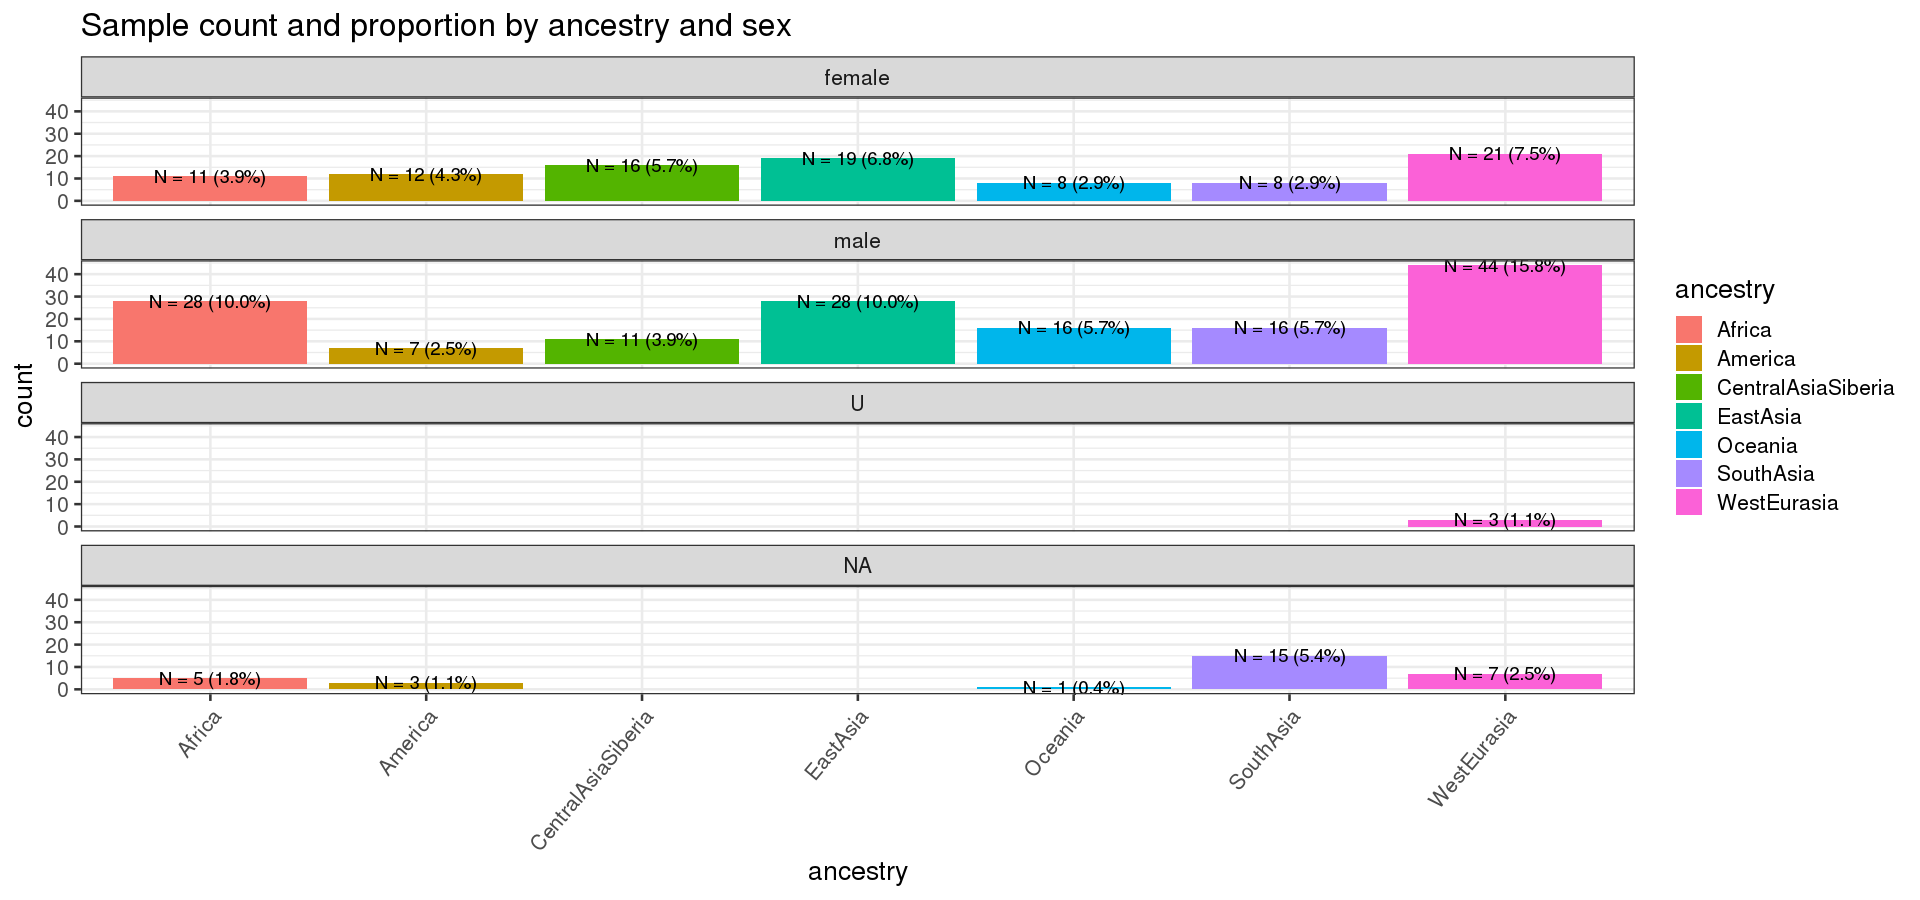

In [12]:
sample_info %>%
  group_by(ancestry, sex) %>%
  summarize(
    count = n(),
    proportion = n() / nrow(.)
  ) %>%
ggplot(aes(x = ancestry, y = count, fill = ancestry)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  geom_text(aes(label = str_glue('N = {count} ({percent(proportion)})'))) +
  facet_wrap( ~ sex, ncol = 1) +
  theme(axis.text.x = element_text(angle = 50, hjust = 1)) +
  ggtitle('Sample count and proportion by ancestry and sex')

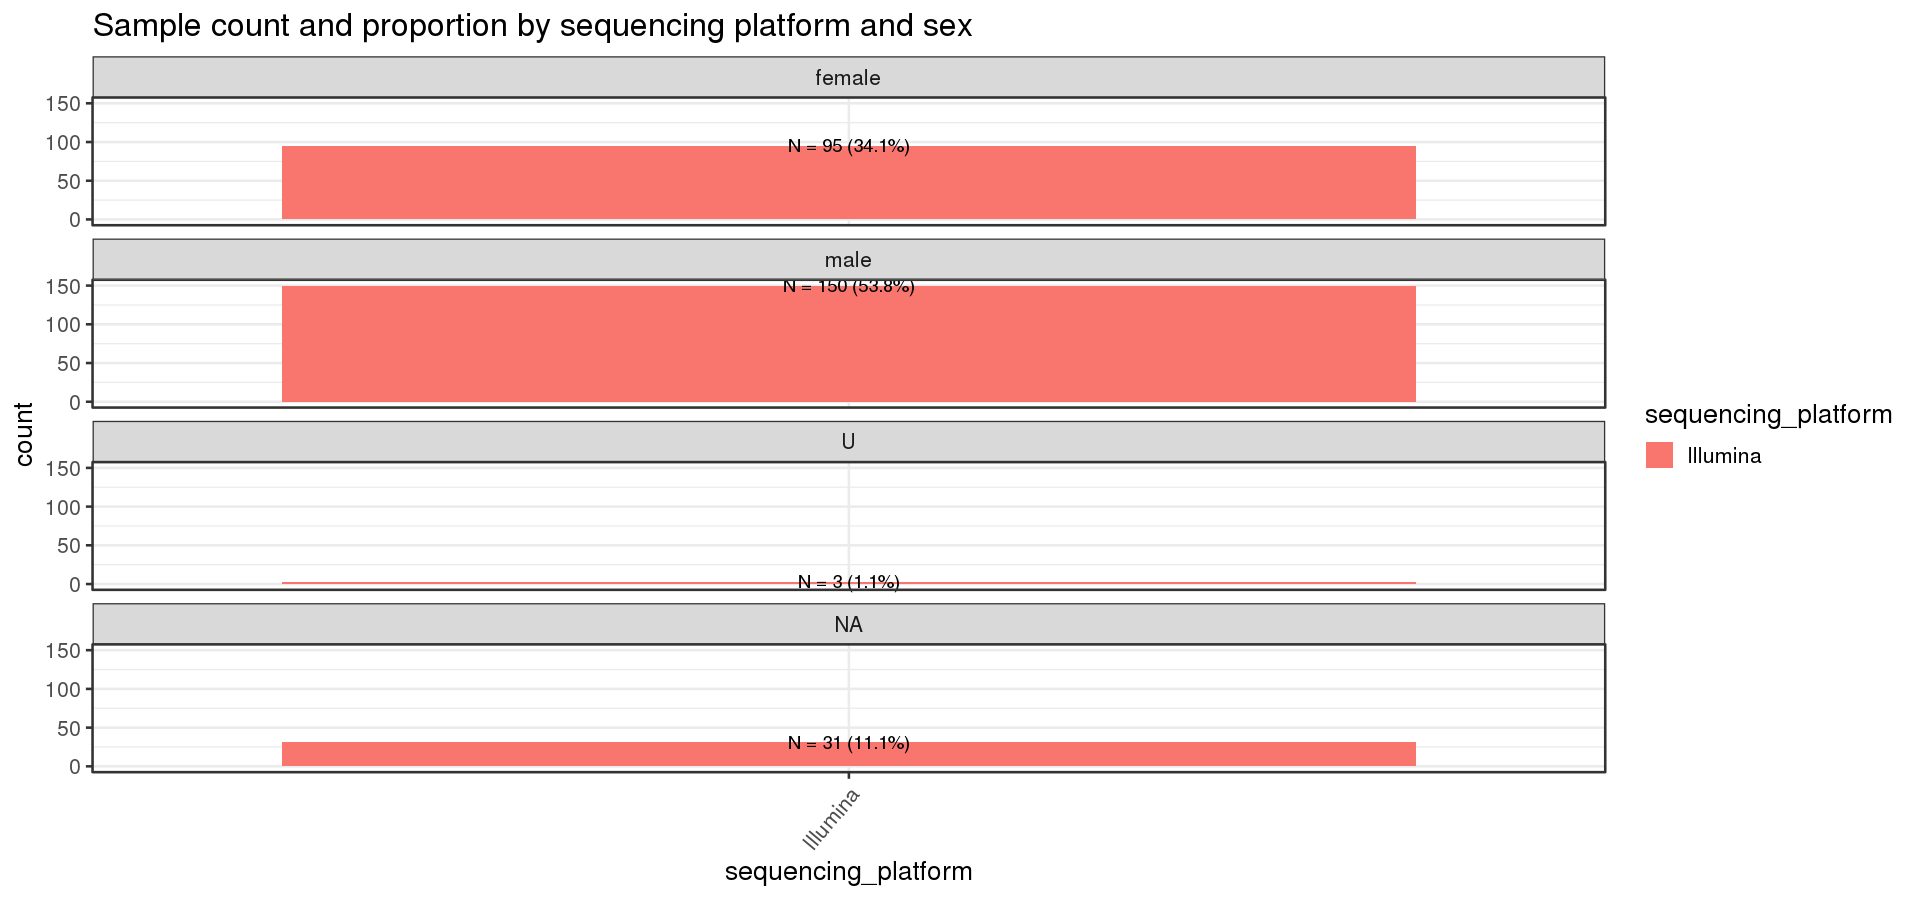

In [13]:
sample_info %>%
  group_by(sequencing_platform, sex) %>%
  summarize(
    count = n(),
    proportion = n() / nrow(.)
  ) %>%
ggplot(aes(x = sequencing_platform, y = count, fill = sequencing_platform)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  geom_text(aes(label = str_glue('N = {count} ({percent(proportion)})'))) +
  coord_cartesian(clip = 'off') +
  facet_wrap(. ~ sex, ncol = 1) +
  theme(axis.text.x = element_text(angle = 50, hjust = 1)) +
  ggtitle('Sample count and proportion by sequencing platform and sex')

# Variant call rate

## Per-chromosome variant call rate

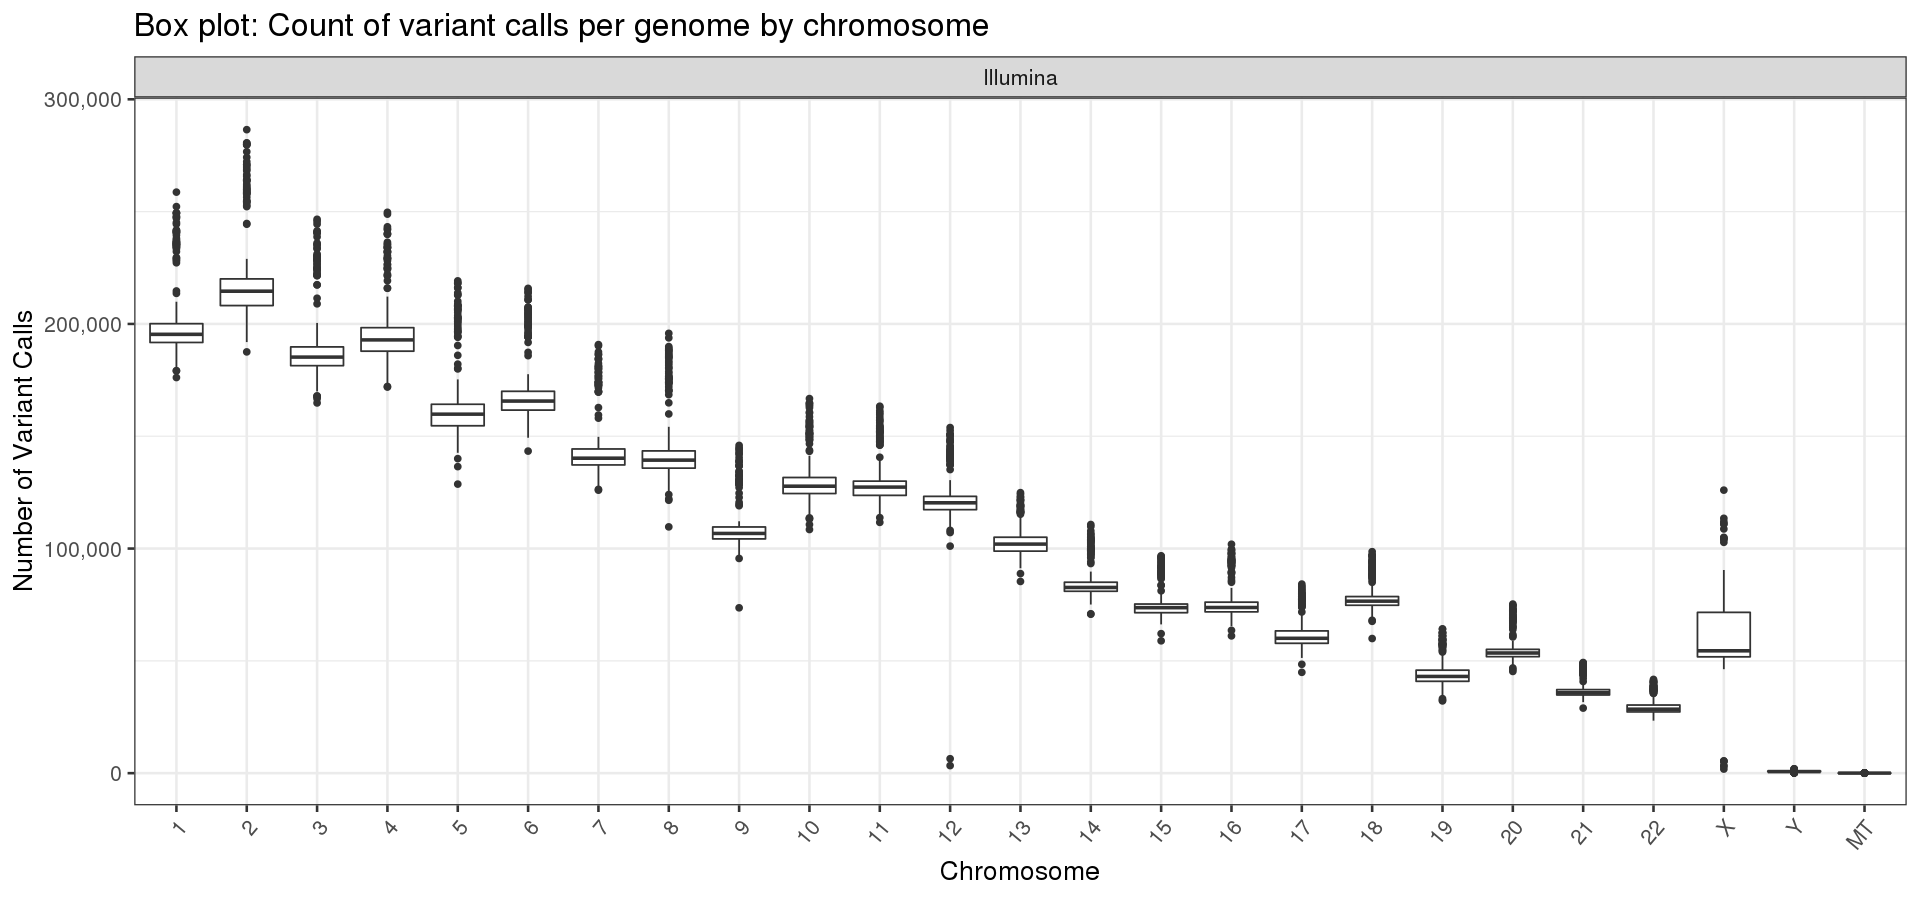

In [14]:
joined_chrom_results %>%
  filter(reference_name %in% c(AUTOSOMES, ALLOSOMES, MITOCHONDRIA)) %>%
  mutate(reference_name = parse_factor(reference_name, levels = c(AUTOSOMES, ALLOSOMES, MITOCHONDRIA))) %>%
ggplot(aes(y = number_of_calls, x = reference_name)) +
  geom_boxplot() +
  scale_y_continuous(labels = comma) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free_y') +
  ylab('Number of Variant Calls') +
  xlab('Chromosome') +
  ggtitle('Box plot: Count of variant calls per genome by chromosome') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

## Display per-chromosome outliers 

Compute per chromosome mean and sd call count

In [15]:
chrom_calls_summary <- joined_chrom_results %>%
    group_by(reference_name, sequencing_platform) %>%
    summarize(
        number_of_calls_mean = mean(number_of_calls),
        number_of_calls_sd = sd(number_of_calls),
    )

head(chrom_calls_summary)

reference_name,sequencing_platform,number_of_calls_mean,number_of_calls_sd
<chr>,<chr>,<dbl>,<dbl>
1,Illumina,200422.60,16661.118
10,Illumina,130481.60,10789.056
11,Illumina,129456.79,10403.734
12,Illumina,121714.31,13744.301
13,Illumina,103062.03,6769.014
14,Illumina,84736.74,7430.972


In [16]:
low_chrom_calls_sd_multiplier <- 3

(chrom_calls_outliers <- joined_chrom_results %>%
    inner_join(chrom_calls_summary) %>%
    filter(number_of_calls < number_of_calls_mean - (low_chrom_calls_sd_multiplier * number_of_calls_sd)) %>%
    arrange(reference_name, number_of_calls))


Joining, by = c("reference_name", "sequencing_platform")


name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,number_of_calls_mean,number_of_calls_sd
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
LP6005441-DNA_B03,12,3369,1837,3369,3369,0.54527,2297,1072,2.142724,Illumina,female,Oceania,121714.31,13744.30
LP6005443-DNA_G01,12,6440,3386,6440,6440,0.52578,4511,1929,2.338517,Illumina,female,EastAsia,121714.31,13744.30
SS6004471,9,73619,26039,73619,73619,0.35370,48294,25325,1.906969,Illumina,male,Africa,109534.75,10566.19
LP6005441-DNA_G09,X,1826,1743,1826,1826,0.95455,1232,594,2.074074,Illumina,NA,WestEurasia,61613.38,16510.37
LP6005443-DNA_C01,X,3101,1613,3101,3101,0.52015,2125,976,2.177254,Illumina,male,EastAsia,61613.38,16510.37
LP6005592-DNA_A02,X,3393,1852,3393,3393,0.54583,2310,1083,2.132964,Illumina,male,WestEurasia,61613.38,16510.37
LP6005442-DNA_C10,X,5141,3438,5141,5141,0.66874,3477,1664,2.089543,Illumina,male,WestEurasia,61613.38,16510.37
LP6005443-DNA_F04,X,5431,4149,5431,5431,0.76395,3700,1731,2.137493,Illumina,male,CentralAsiaSiberia,61613.38,16510.37
LP6005443-DNA_E06,X,5450,3471,5450,5450,0.63688,3626,1824,1.987939,Illumina,male,Africa,61613.38,16510.37


In [17]:
problems <- chrom_calls_outliers %>%
                 group_by(name) %>%
                 summarize(
                     fail = str_glue('per chrom variant count is at least {low_chrom_calls_sd_multiplier}',
                                     ' standard deviations below the platform mean for ',
                                     str_c(reference_name, collapse = ',')))

dim(problems)
head(problems)

[1] 9 2

name,fail
<chr>,<glue>
LP6005441-DNA_B03,per chrom variant count is at least 3 standard deviations below the platform mean for 12
LP6005441-DNA_G09,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005442-DNA_C10,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_C01,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_E06,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_F04,per chrom variant count is at least 3 standard deviations below the platform mean for X


## Per-genome variant call rate

Warning message:
“Removed 31 rows containing missing values (geom_point).”

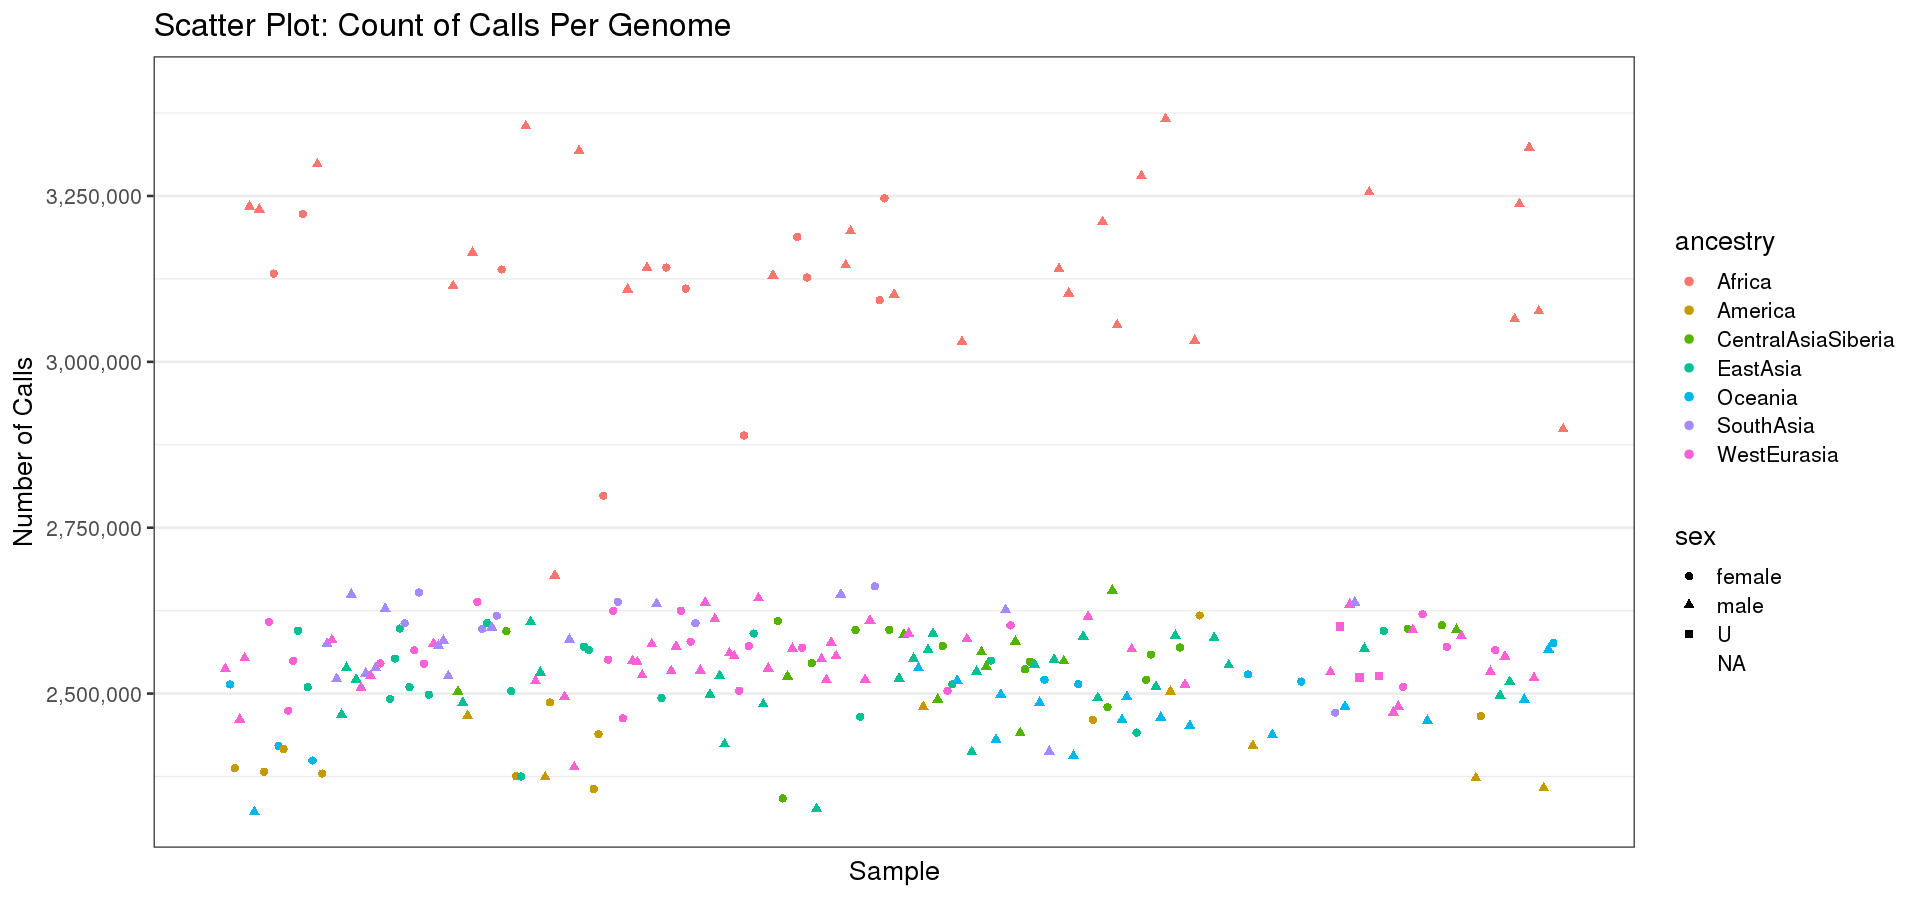

In [18]:
genome_call_rate_summary <- joined_chrom_results %>%
  group_by(name, sex, ancestry) %>%
  summarize(n = sum(number_of_calls))

p <- genome_call_rate_summary %>%
  ggplot() +
  geom_point(aes(x = name, y = n, color = ancestry, shape = sex)) +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(labels = comma) +
  xlab('Sample') +
  ylab('Number of Calls') +
  ggtitle('Scatter Plot: Count of Calls Per Genome') +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
if (nrow(genome_call_rate_summary) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

Warning message:
“Removed 31 rows containing missing values (geom_point).”

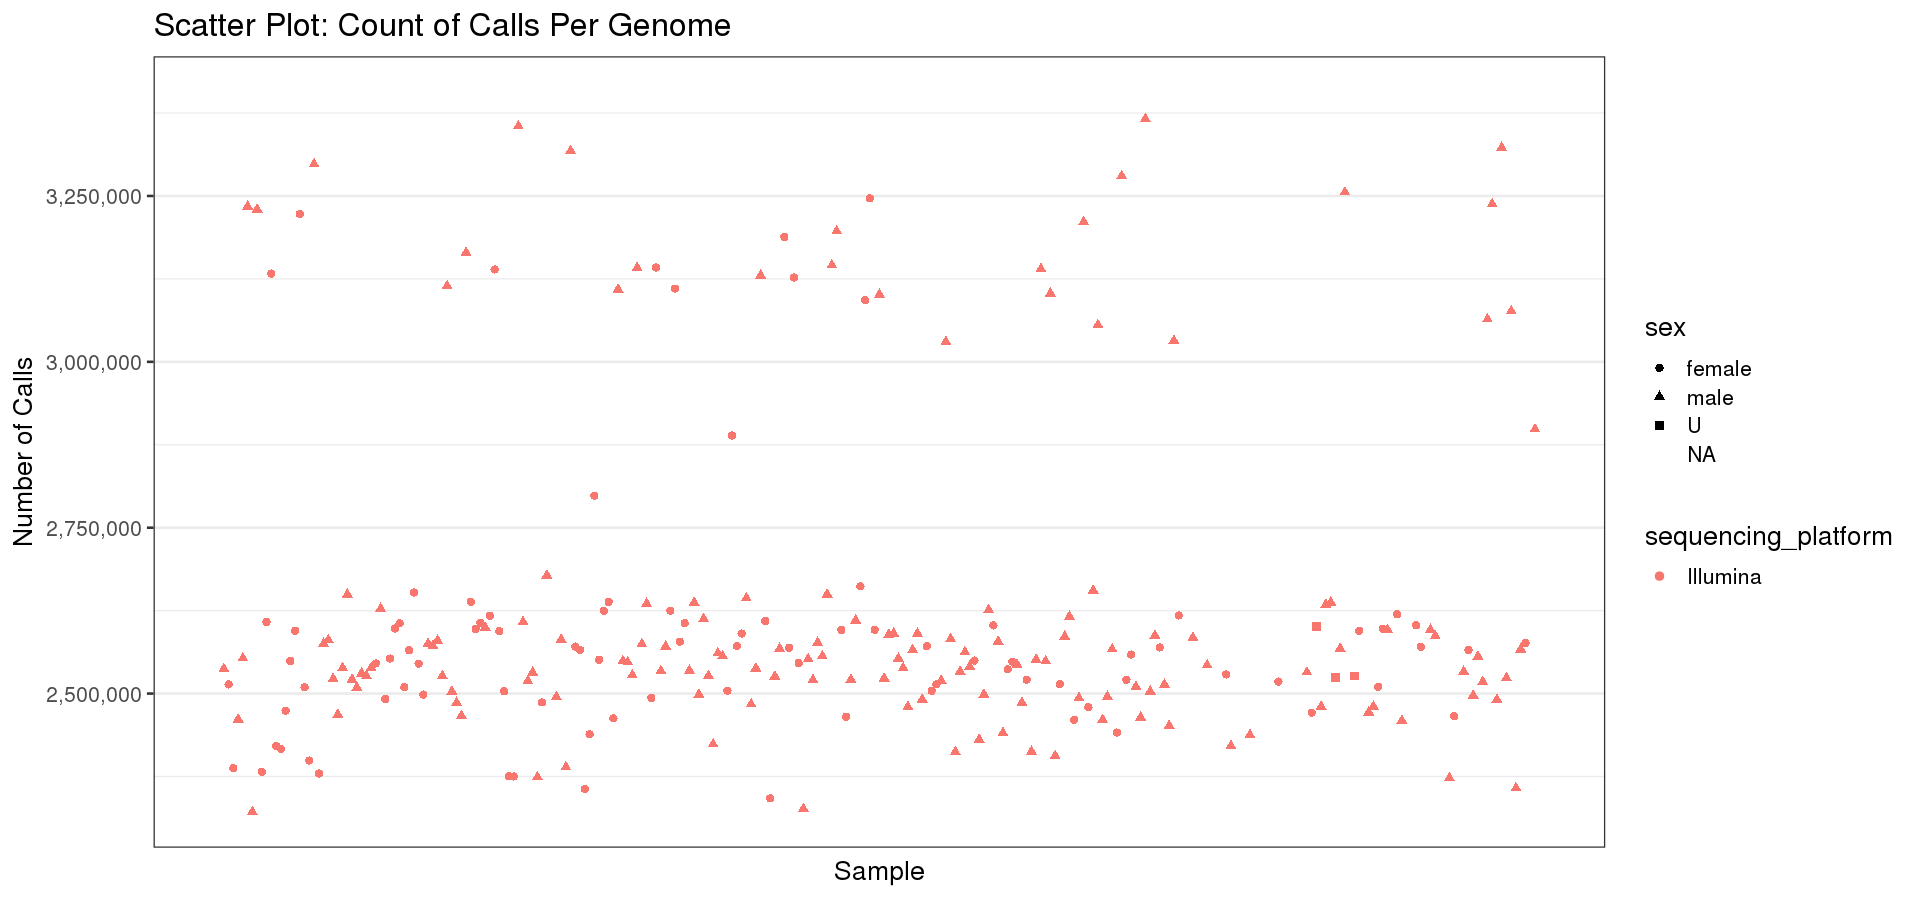

In [19]:
genome_call_rate_summary <- joined_chrom_results %>%
  group_by(name, sex, sequencing_platform) %>%
  summarize(n = sum(number_of_calls))

p <- genome_call_rate_summary %>%
  ggplot() +
  geom_point(aes(x = name, y = n, color = sequencing_platform, shape = sex)) +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(labels = comma) +
  xlab('Sample') +
  ylab('Number of Calls') +
  ggtitle('Scatter Plot: Count of Calls Per Genome') +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
if (nrow(genome_call_rate_summary) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display per-genome outliers 

In [20]:
genome_calls_summary <- genome_call_rate_summary %>%
    group_by(sequencing_platform) %>%
    summarize(
        genome_calls_mean = mean(n),
        genome_calls_sd = sd(n),
    )

head(genome_calls_summary)

sequencing_platform,genome_calls_mean,genome_calls_sd
<chr>,<dbl>,<dbl>
Illumina,2628486,237032.8


In [21]:
low_genome_calls_sd_multiplier <- 3

(genome_calls_outliers <- genome_call_rate_summary %>%
    inner_join(genome_calls_summary) %>%
    filter(n < genome_calls_mean - (low_genome_calls_sd_multiplier * genome_calls_sd)) %>%
    arrange(n))

Joining, by = "sequencing_platform"


name,sex,sequencing_platform,n,genome_calls_mean,genome_calls_sd
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>


In [22]:
problems <- rbind(
    tibble(name = unique(genome_calls_outliers$name),
           fail = str_glue('per genome variant count is at least {low_genome_calls_sd_multiplier}',
                           ' standard deviations below the platform mean')),
    problems)

dim(problems)
head(problems)

[1] 9 2

name,fail
<chr>,<glue>
LP6005441-DNA_B03,per chrom variant count is at least 3 standard deviations below the platform mean for 12
LP6005441-DNA_G09,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005442-DNA_C10,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_C01,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_E06,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_F04,per chrom variant count is at least 3 standard deviations below the platform mean for X


# Missingness rate

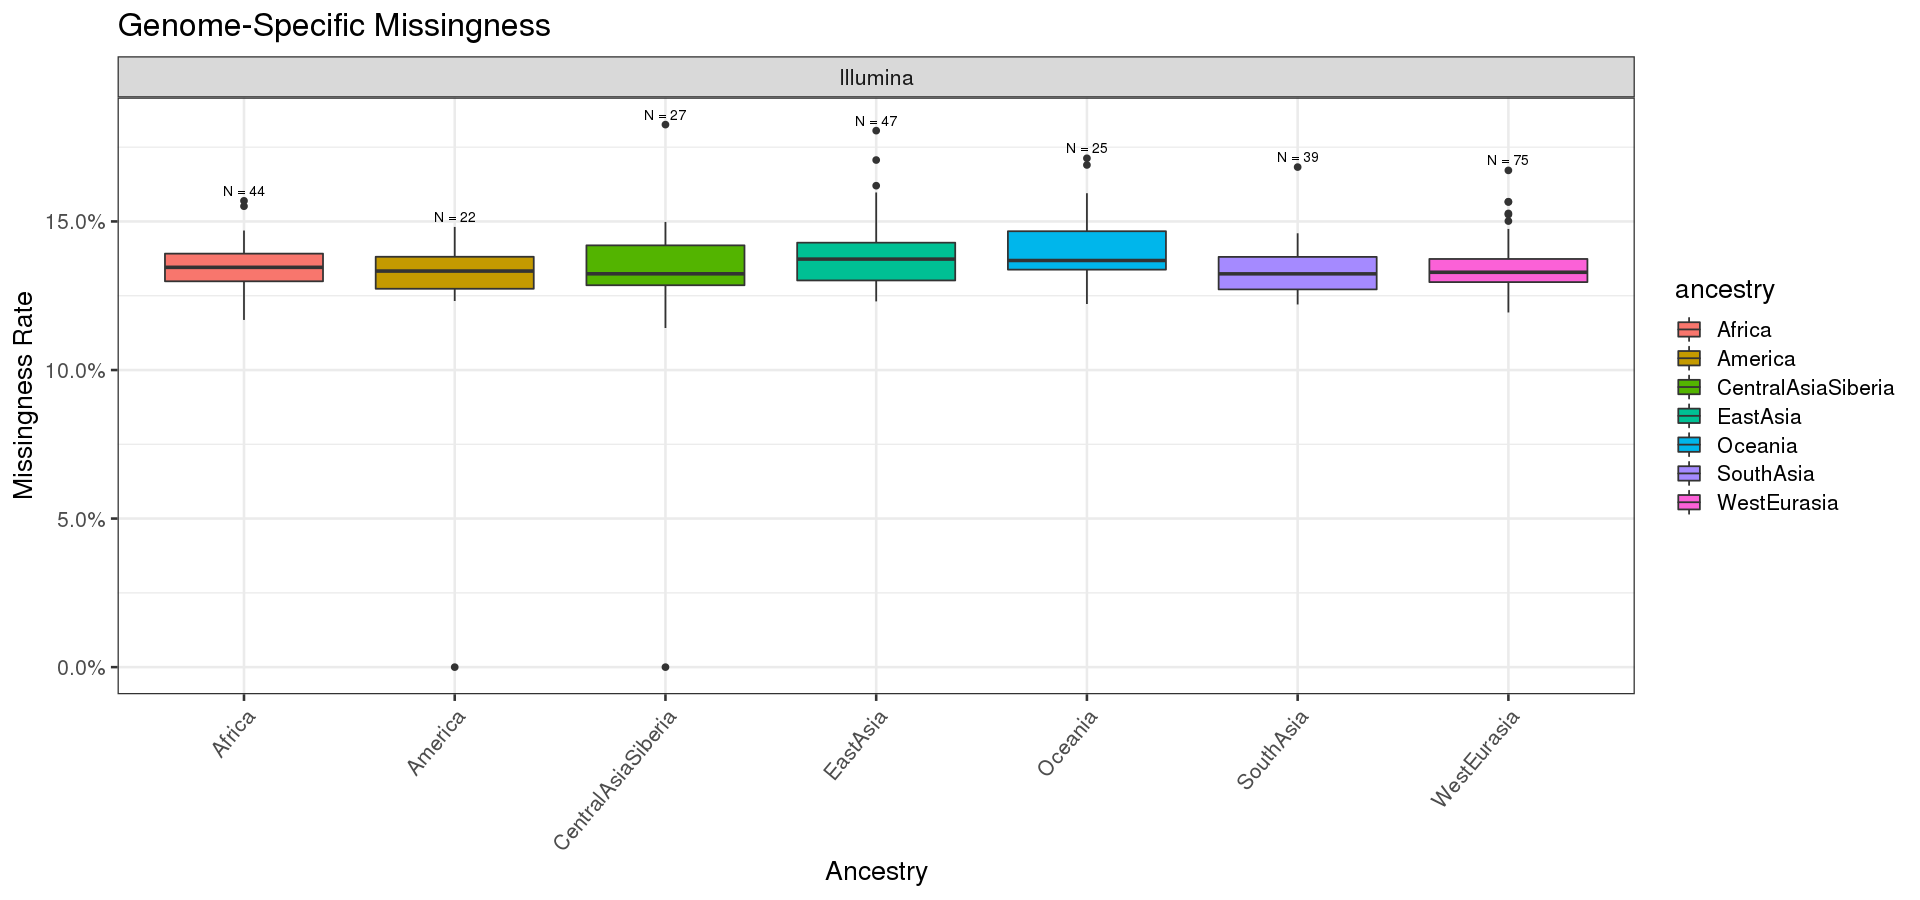

In [23]:
joined_genome_results %>%
ggplot(aes(y = missingness_rate, x = ancestry, fill = ancestry)) +
  geom_boxplot() +
  stat_summary(fun.data = get_boxplot_fun_data, geom = 'text', size = 3,
               position = position_dodge(width = 0.9), vjust = -0.5) +
  scale_y_continuous(labels = percent_format()) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free_y') +
  ylab('Missingness Rate') +
  xlab('Ancestry') +
  ggtitle('Genome-Specific Missingness') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

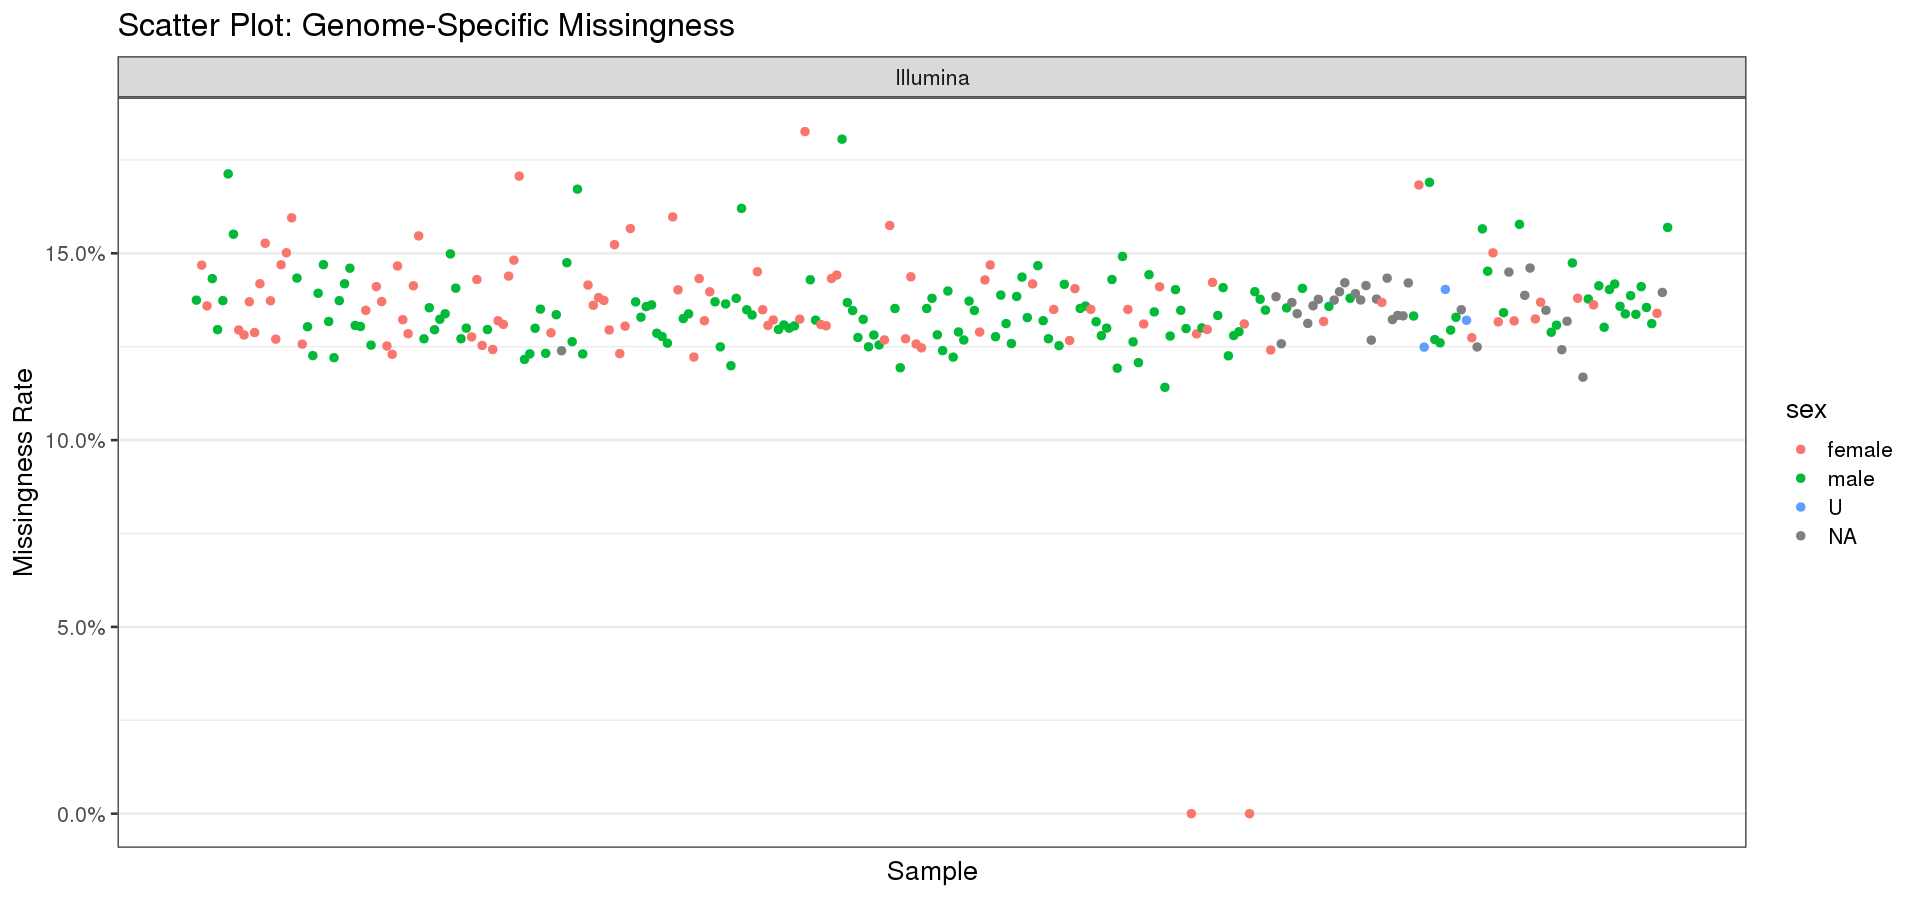

In [24]:
p <- joined_genome_results %>%
  ggplot(aes(x = name, y = missingness_rate, color = sex)) +
  geom_point() +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(limits = c(0, NA), labels = percent_format()) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free') +
  xlab('Sample') +
  ylab('Missingness Rate') +
  ggtitle('Scatter Plot: Genome-Specific Missingness')
if (nrow(joined_genome_results) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display outliers 

In [25]:
(missingness_summary <- joined_genome_results %>%
    group_by(sequencing_platform) %>%
    summarize(
        missingness_rate_mean = mean(missingness_rate),
        missingness_rate_sd = sd(missingness_rate),
    ))

sequencing_platform,missingness_rate_mean,missingness_rate_sd
<chr>,<dbl>,<dbl>
Illumina,0.13484,0.01535446


In [26]:
low_missingness_sd_multiplier <- 3

(low_missingness_outliers <- joined_genome_results %>%
     inner_join(missingness_summary) %>%
     filter(
         missingness_rate < missingness_rate_mean - (low_missingness_sd_multiplier * missingness_rate_sd)
     ) %>%
     arrange(missingness_rate))

Joining, by = "sequencing_platform"


name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,missingness_rate_mean,missingness_rate_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
LP6005443-DNA_F11,0,3933469,0,NA,NA,NA,NA,NA,NA,Illumina,female,America,0.13484,0.01535446
LP6005443-DNA_H03,0,4020324,0,NA,NA,NA,NA,NA,NA,Illumina,female,CentralAsiaSiberia,0.13484,0.01535446


In [27]:
high_missingness_sd_multiplier <- 3

(high_missingness_outliers <- joined_genome_results %>%
     inner_join(missingness_summary) %>%
     filter(missingness_rate > missingness_rate_mean + (high_missingness_sd_multiplier * missingness_rate_sd)) %>%
     arrange(desc(missingness_rate)))

Joining, by = "sequencing_platform"


name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,missingness_rate_mean,missingness_rate_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
LP6005442-DNA_F01,751115,4113717,0.1825879,26798,1346092,0.599,0.401,24889,37170,Illumina,female,CentralAsiaSiberia,0.13484,0.01535446


In [28]:
problems <- rbind(
    tibble(name = unique(high_missingness_outliers$name),
           fail = str_glue('per genome missingness rate is at least {high_missingness_sd_multiplier}',
                           ' standard deviations above the platform mean')),
    tibble(name = unique(low_missingness_outliers$name),
           fail = str_glue('per genome missingness rate is at least {low_missingness_sd_multiplier}',
                           ' standard deviations below the platform mean')),
    problems)

dim(problems)
head(problems)

[1] 12  2

name,fail
<chr>,<glue>
LP6005442-DNA_F01,per genome missingness rate is at least 3 standard deviations above the platform mean
LP6005443-DNA_F11,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005443-DNA_H03,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005441-DNA_B03,per chrom variant count is at least 3 standard deviations below the platform mean for 12
LP6005441-DNA_G09,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005442-DNA_C10,per chrom variant count is at least 3 standard deviations below the platform mean for X


# Singleton rate

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”

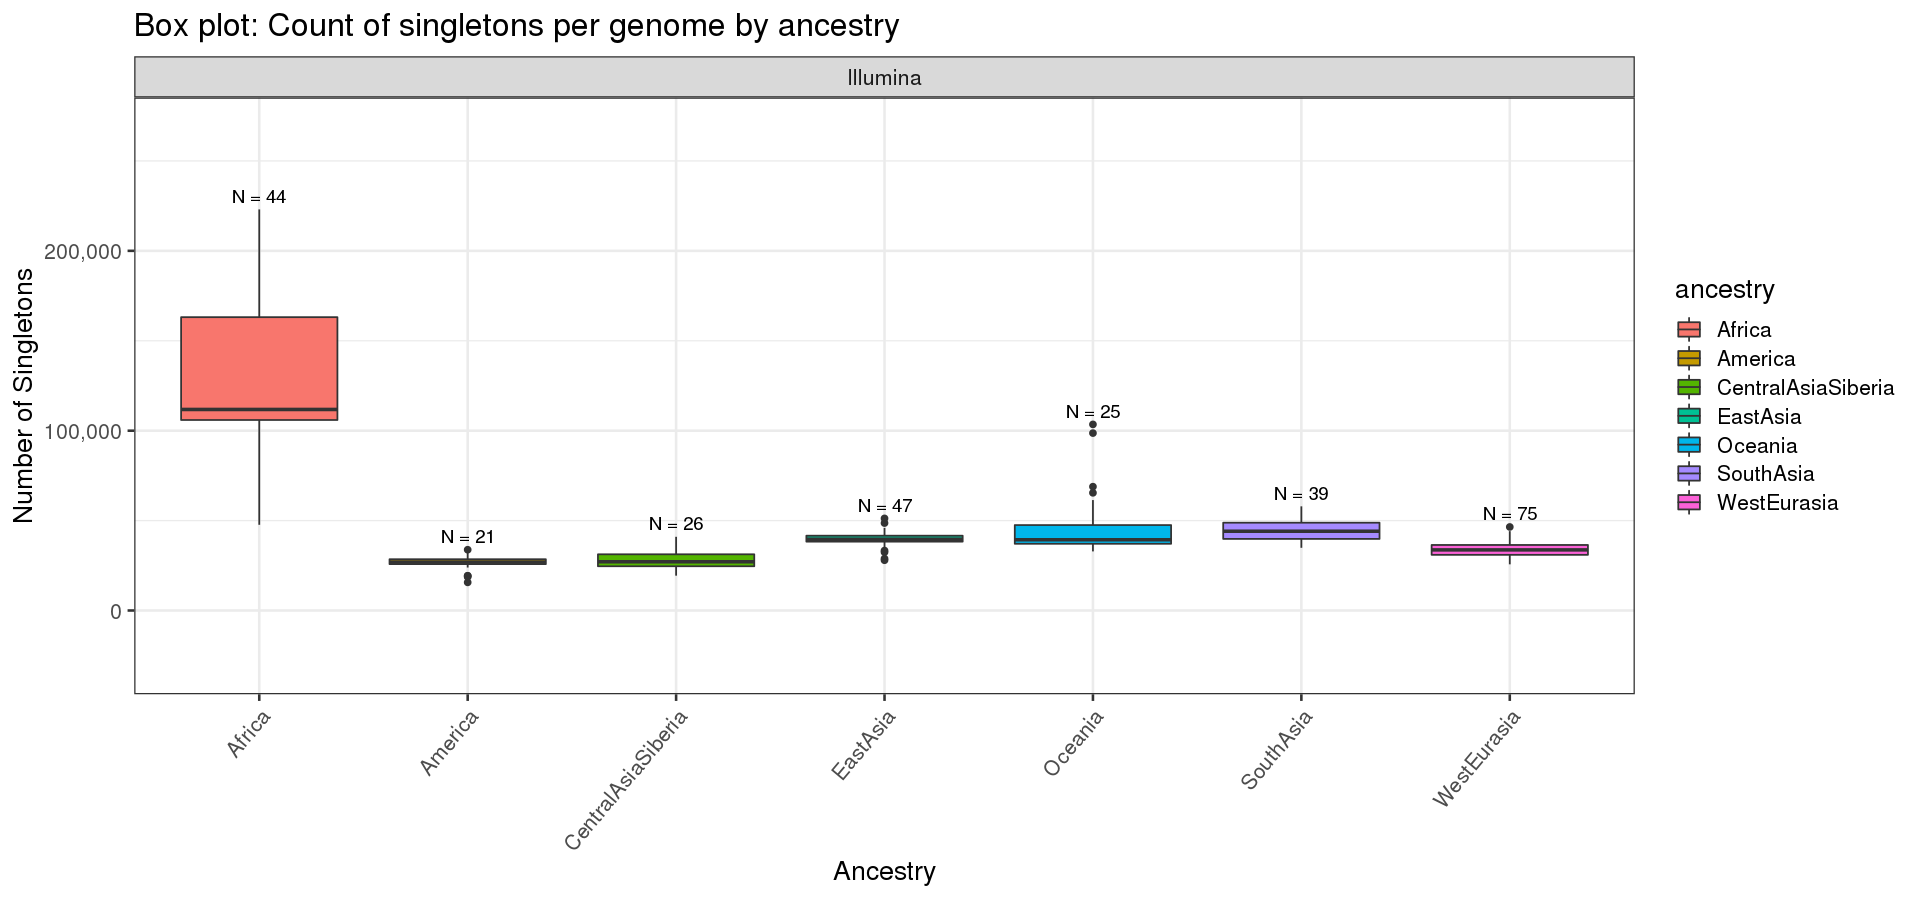

In [29]:
joined_genome_results %>%
  ggplot(aes(y = private_variant_count, x = ancestry, fill = ancestry)) +
  geom_boxplot() +
  stat_summary(fun.data = get_boxplot_fun_data, geom = 'text',
               position = position_dodge(width = 0.9), vjust = -0.5) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free_y') +
  scale_y_continuous(labels = comma, expand = c(0.3, 0)) +
  ylab('Number of Singletons') +
  xlab('Ancestry') +
  ggtitle('Box plot: Count of singletons per genome by ancestry') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

Warning message:
“Removed 2 rows containing missing values (geom_point).”

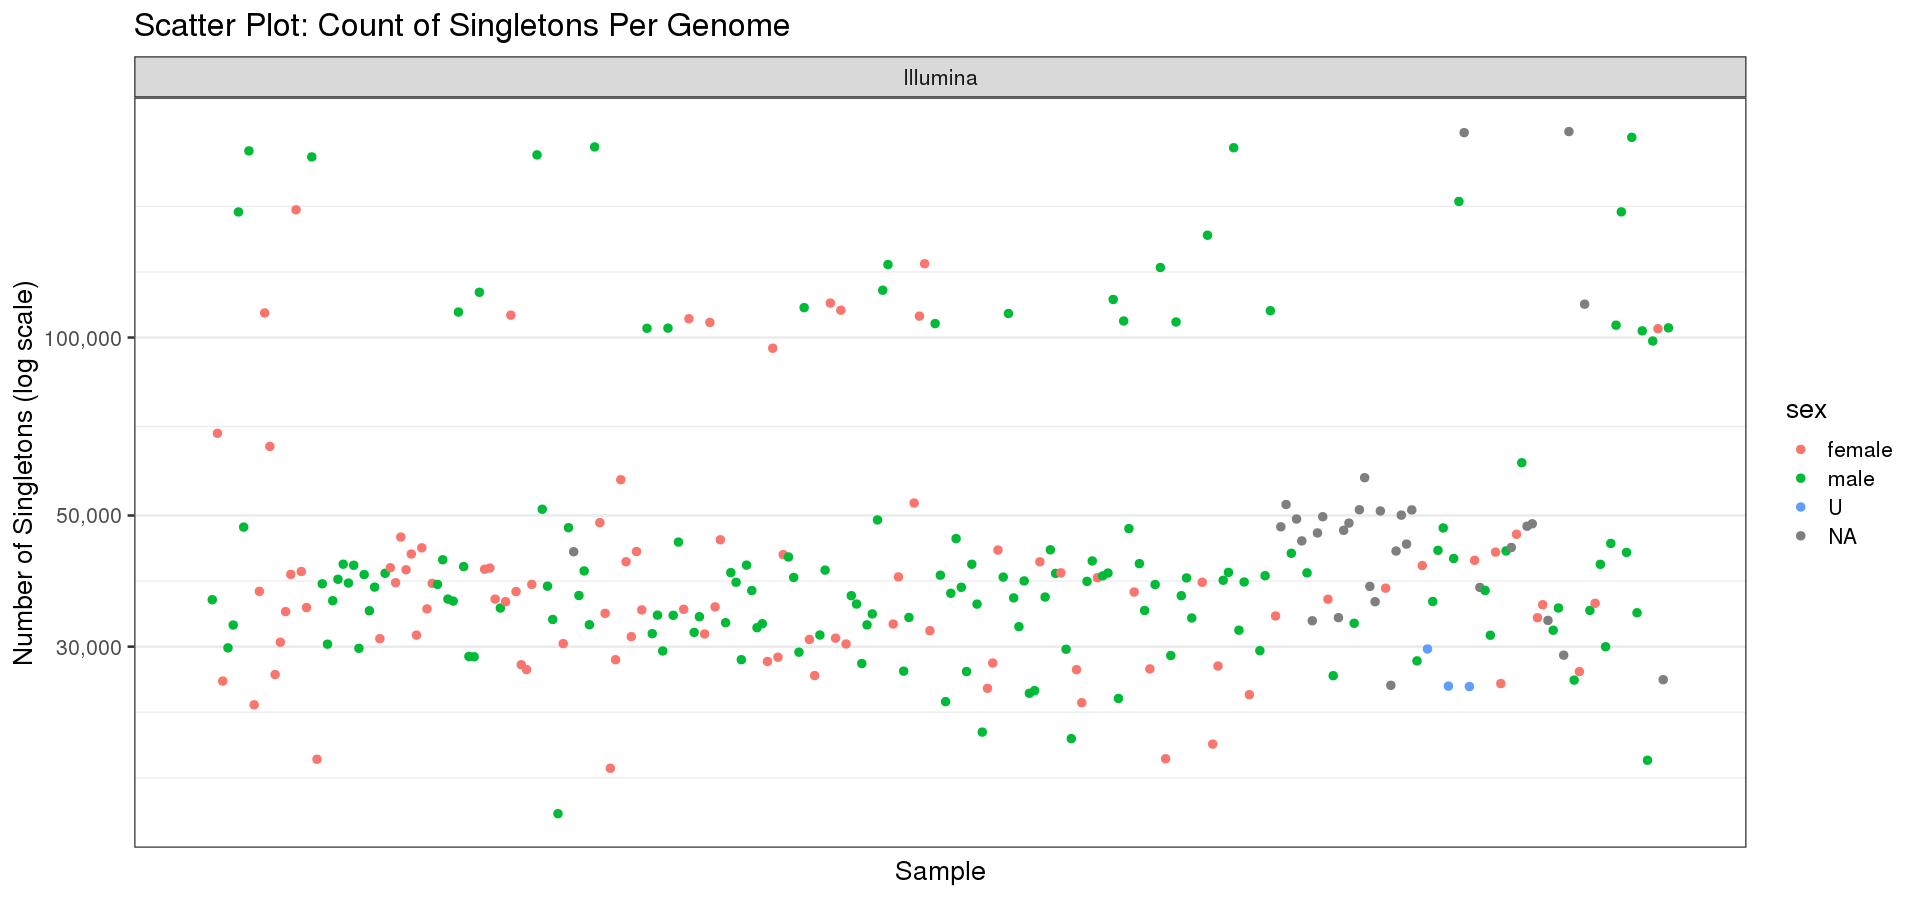

In [30]:
p <- joined_genome_results %>%
  ggplot(aes(x = name, y = private_variant_count, color = sex)) +
  geom_point() +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_log10(labels = comma) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free') +
  xlab('Sample') +
  ylab('Number of Singletons (log scale)') +
  ggtitle('Scatter Plot: Count of Singletons Per Genome')
if (nrow(joined_genome_results) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display outliers 

In [31]:
(singleton_summary <- joined_genome_results %>%
     group_by(sequencing_platform, ancestry) %>%
     summarize(
         singleton_count_mean = mean(private_variant_count),
         singleton_count_sd = sd(private_variant_count),
     ))

sequencing_platform,ancestry,singleton_count_mean,singleton_count_sd
<chr>,<chr>,<dbl>,<dbl>
Illumina,Africa,129941.91,47340.445
Illumina,America,NA,NA
Illumina,CentralAsiaSiberia,NA,NA
Illumina,EastAsia,39639.74,4331.256
Illumina,Oceania,47300.68,18688.494
Illumina,SouthAsia,44108.92,5729.143
Illumina,WestEurasia,34190.81,4668.445


In [32]:
high_singleton_sd_multiplier <- 3

(high_singleton_outliers <- joined_genome_results %>%
     inner_join(singleton_summary) %>%
     filter(private_variant_count > singleton_count_mean + (high_singleton_sd_multiplier * singleton_count_sd)) %>%
     arrange(desc(private_variant_count)))

Joining, by = c("sequencing_platform", "ancestry")


name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,singleton_count_mean,singleton_count_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
SS6004478,550395,4109729,0.1339249,103490,1372511,0.51,0.49,35219,36586,Illumina,female,Oceania,47300.68,18688.49


In [33]:
problems <- rbind(
    tibble(name = high_singleton_outliers$name,
           fail = str_glue('singleton count at least {high_singleton_sd_multiplier}',
           ' standard deviations above the ancestry and platform mean')),
    problems)

dim(problems)
head(problems)

[1] 13  2

name,fail
<chr>,<glue>
SS6004478,singleton count at least 3 standard deviations above the ancestry and platform mean
LP6005442-DNA_F01,per genome missingness rate is at least 3 standard deviations above the platform mean
LP6005443-DNA_F11,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005443-DNA_H03,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005441-DNA_B03,per chrom variant count is at least 3 standard deviations below the platform mean for 12
LP6005441-DNA_G09,per chrom variant count is at least 3 standard deviations below the platform mean for X


# Heterozygosity rate

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”

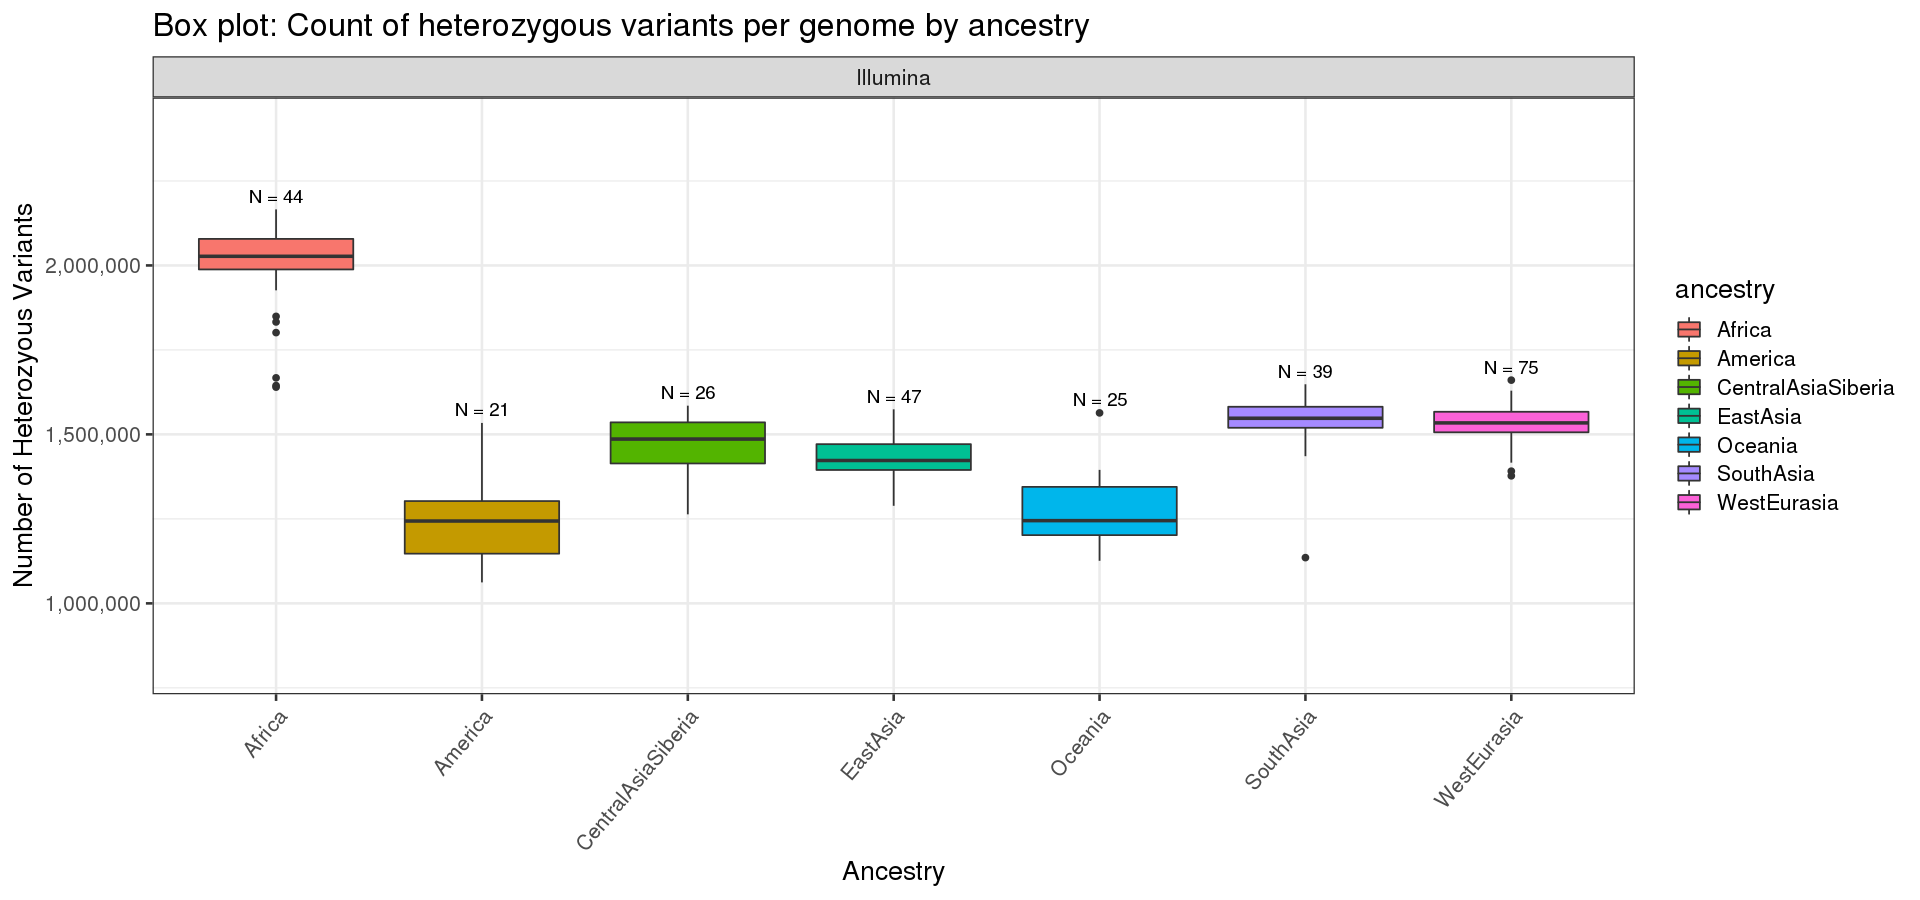

In [34]:
ggplot(joined_genome_results,
       aes(y = heterozygous_variant_count, x = ancestry, fill = ancestry)) +
  geom_boxplot() +
  stat_summary(fun.data = get_boxplot_fun_data, geom = 'text',
               position = position_dodge(width = 0.9), vjust = -0.5) +
  scale_y_continuous(labels = comma, expand = c(0.3, 0)) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free_y') +
  ylab('Number of Heterozyous Variants') +
  xlab('Ancestry') +
  ggtitle('Box plot: Count of heterozygous variants per genome by ancestry') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

Warning message:
“Removed 2 rows containing missing values (geom_point).”

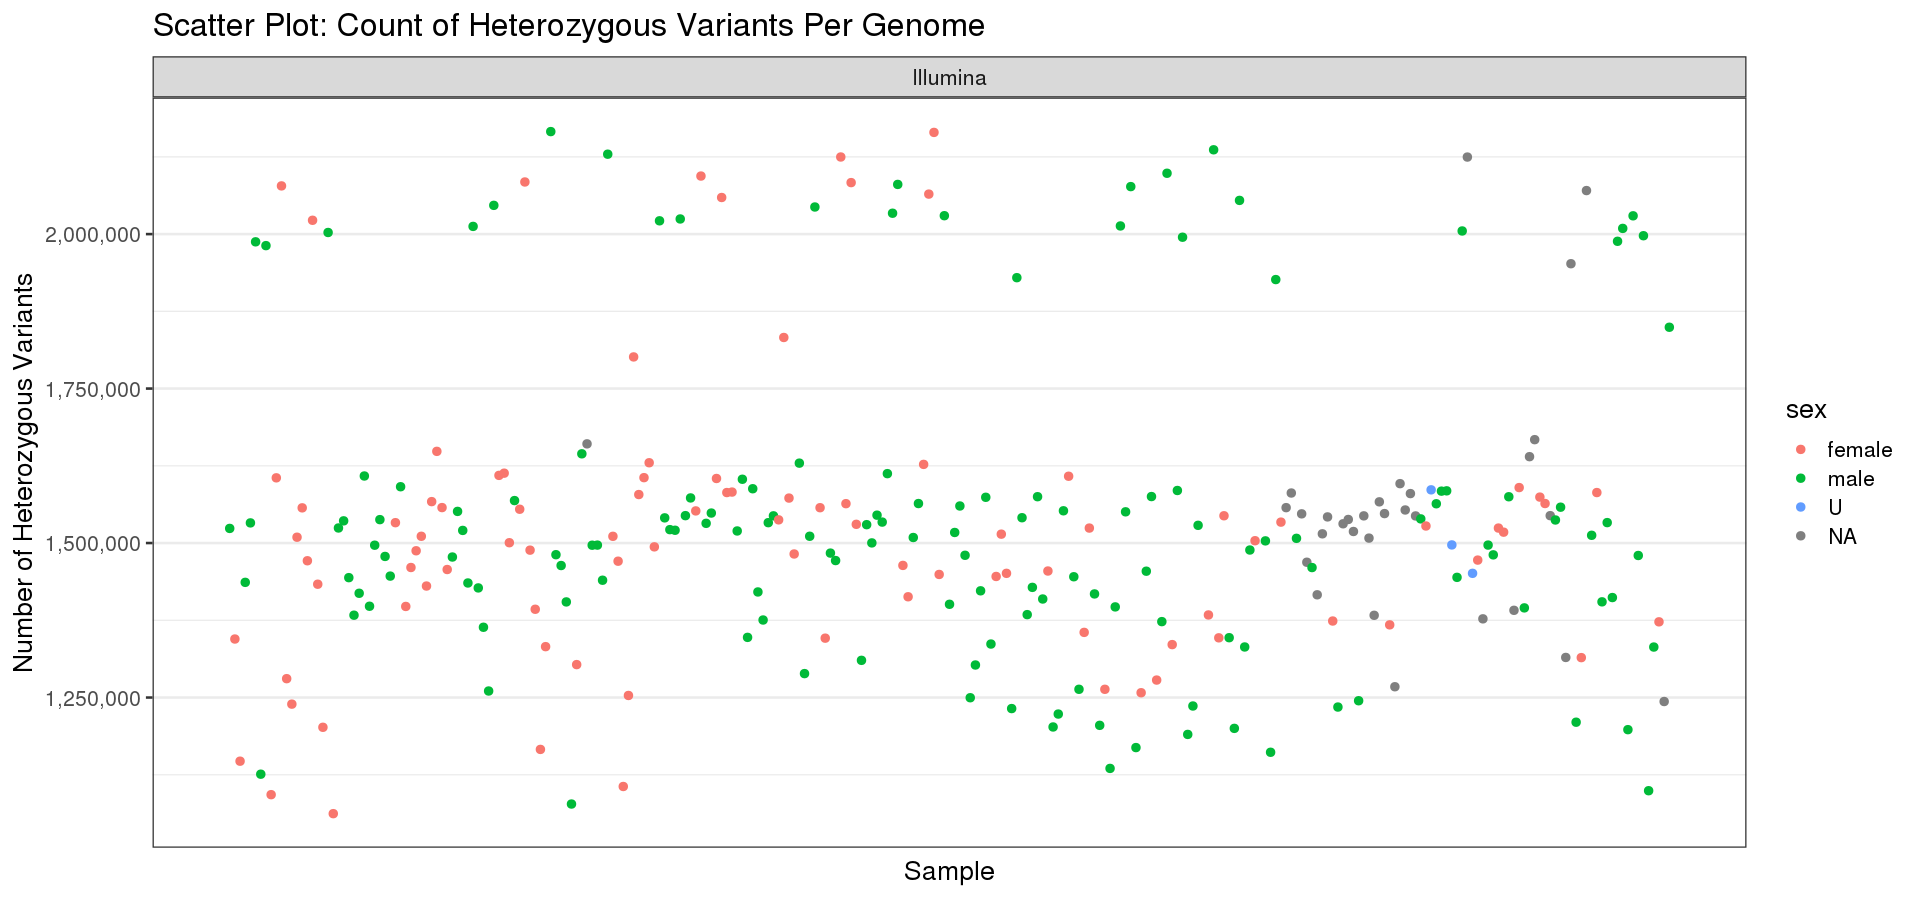

In [35]:
p <- ggplot(joined_genome_results) +
  geom_point(aes(x = name, y = heterozygous_variant_count, color = sex)) +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(labels = comma) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free') +
  xlab('Sample') +
  ylab('Number of Heterozygous Variants') +
  ggtitle('Scatter Plot: Count of Heterozygous Variants Per Genome')
if (nrow(joined_genome_results) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display outliers 

In [36]:
(heterozygous_variant_count_summary <- joined_genome_results %>%
    group_by(sequencing_platform, ancestry) %>%
    summarize(
        heterozygous_variant_count_mean = mean(heterozygous_variant_count),
        heterozygous_variant_count_sd = sd(heterozygous_variant_count),
    ))

sequencing_platform,ancestry,heterozygous_variant_count_mean,heterozygous_variant_count_sd
<chr>,<chr>,<dbl>,<dbl>
Illumina,Africa,2004011,124492.59
Illumina,America,NA,NA
Illumina,CentralAsiaSiberia,NA,NA
Illumina,EastAsia,1428578,58931.13
Illumina,Oceania,1270962,98640.50
Illumina,SouthAsia,1538952,83020.18
Illumina,WestEurasia,1533601,52577.87


In [37]:
low_het_count_sd_multiplier <- 3

(low_heterozygous_variant_count_outliers <- joined_genome_results %>%
     inner_join(heterozygous_variant_count_summary) %>%
     filter(heterozygous_variant_count
            < heterozygous_variant_count_mean - (low_het_count_sd_multiplier * heterozygous_variant_count_sd)
     ) %>%
     arrange(heterozygous_variant_count))

Joining, by = c("sequencing_platform", "ancestry")


name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,heterozygous_variant_count_mean,heterozygous_variant_count_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
LP6005443-DNA_D09,510134,3873589,0.1316954,39514,1135303,0.009,0.991,53132,472,Illumina,male,SouthAsia,1538952,83020.18


In [38]:
high_het_count_sd_multiplier <- 3

(high_heterozygous_variant_count_outliers <- joined_genome_results %>%
     inner_join(heterozygous_variant_count_summary) %>%
     filter(heterozygous_variant_count
            > heterozygous_variant_count_mean + (high_het_count_sd_multiplier * heterozygous_variant_count_sd)
     ) %>%
     arrange(desc(heterozygous_variant_count)))

Joining, by = c("sequencing_platform", "ancestry")


name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,heterozygous_variant_count_mean,heterozygous_variant_count_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>


In [39]:
problems <- rbind(
    tibble(name = low_heterozygous_variant_count_outliers$name,
           fail = str_glue('heterozygous variant count at least {low_het_count_sd_multiplier}',
                           ' standard deviations below the ancestry and platform mean')),
    tibble(name = low_heterozygous_variant_count_outliers$name,
           fail = str_glue('heterozygous variant count at least {high_het_count_sd_multiplier}',
                           ' standard deviations above the ancestry and platform mean')),
    problems)

dim(problems)
head(problems)

[1] 15  2

name,fail
<chr>,<glue>
LP6005443-DNA_D09,heterozygous variant count at least 3 standard deviations below the ancestry and platform mean
LP6005443-DNA_D09,heterozygous variant count at least 3 standard deviations above the ancestry and platform mean
SS6004478,singleton count at least 3 standard deviations above the ancestry and platform mean
LP6005442-DNA_F01,per genome missingness rate is at least 3 standard deviations above the platform mean
LP6005443-DNA_F11,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005443-DNA_H03,per genome missingness rate is at least 3 standard deviations below the platform mean


# Homozygosity rate

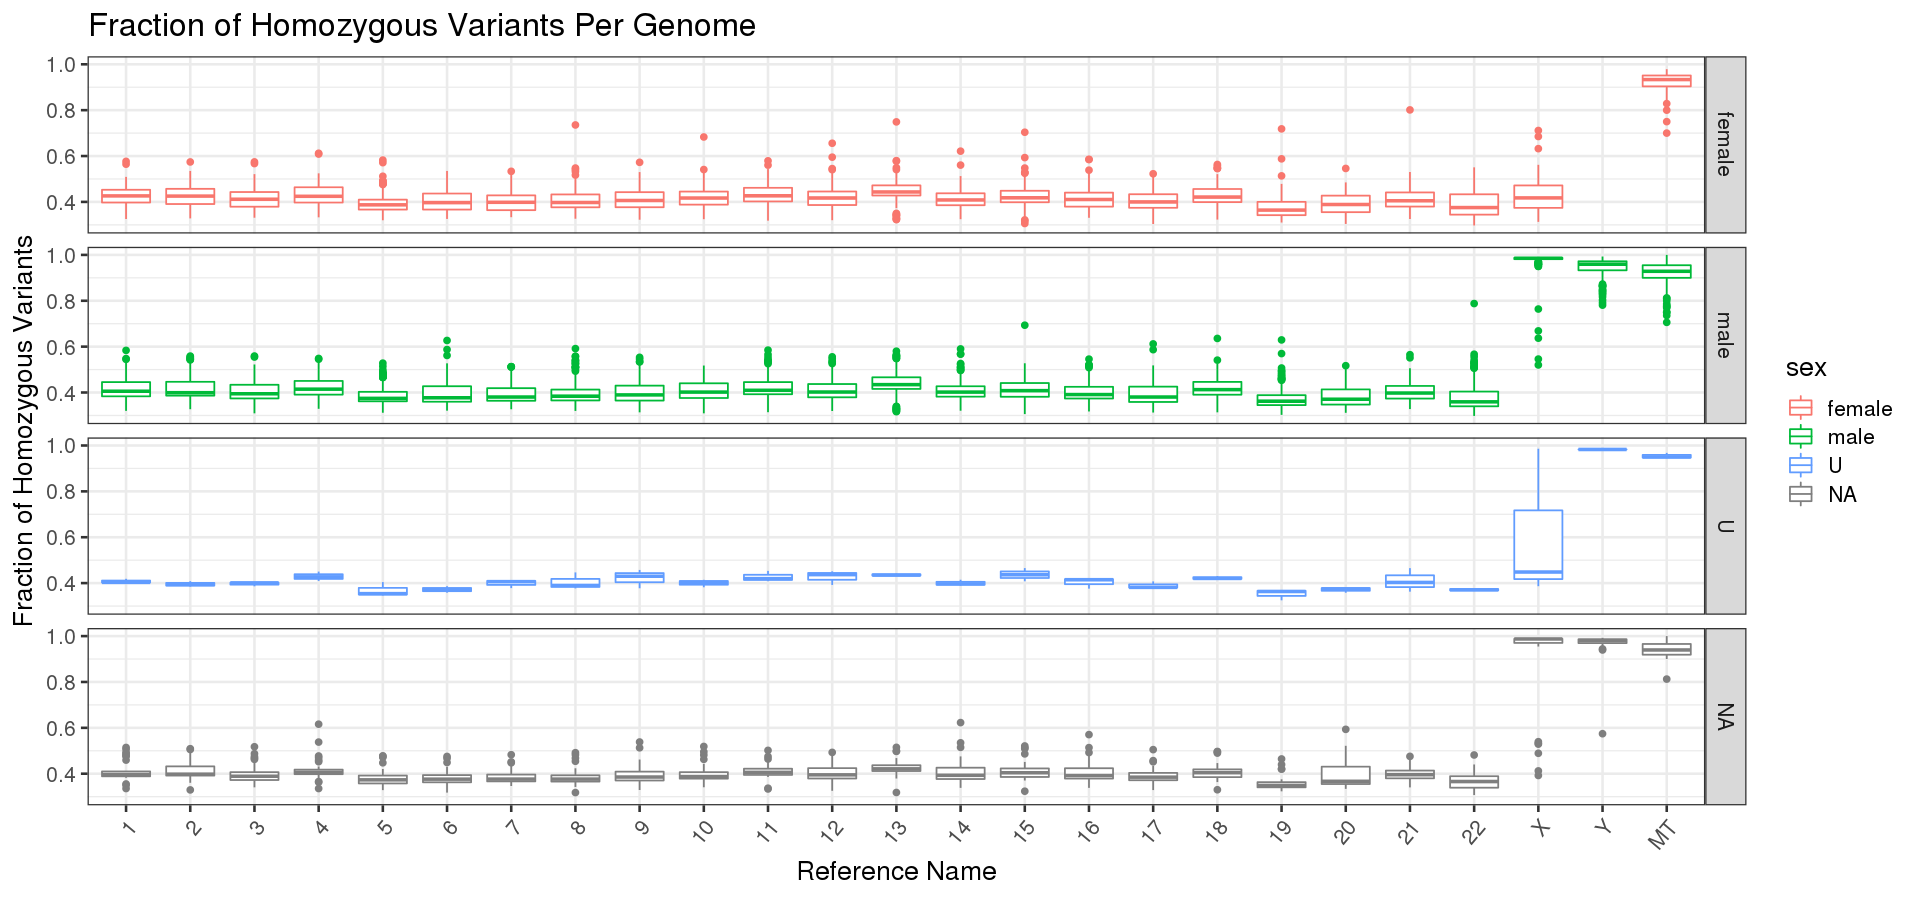

In [40]:
joined_chrom_results %>%
  filter(reference_name %in% c(AUTOSOMES, ALLOSOMES, MITOCHONDRIA)) %>%
  mutate(reference_name = parse_factor(reference_name, levels = c(AUTOSOMES, ALLOSOMES, MITOCHONDRIA))) %>%
  ggplot(aes(y = F, x = reference_name, color = sex)) +
  geom_boxplot() +
  facet_grid(sex ~ .) +
  ylab('Fraction of Homozygous Variants') +
  xlab('Reference Name') +
  ggtitle('Fraction of Homozygous Variants Per Genome') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

In [41]:
head(fraction_homozygous_summary <- joined_chrom_results %>%
    group_by(reference_name) %>%
    summarize(
        F_mean = mean(F),
        F_sd = sd(F),
    ))

reference_name,F_mean,F_sd
<chr>,<dbl>,<dbl>
1,0.4188419,0.05076990
10,0.4111918,0.04964400
11,0.4221581,0.05315690
12,0.4158390,0.05427126
13,0.4404229,0.05769077
14,0.4116191,0.05125374


## Display per-chromosome outliers 

In [42]:
low_fraction_homozygous_sd_multiplier <- 4

(low_hom_outliers <- joined_chrom_results %>%
    inner_join(fraction_homozygous_summary) %>%
    filter(F < F_mean - (low_fraction_homozygous_sd_multiplier * F_sd)) %>%
    arrange(sex, reference_name, F))

Joining, by = "reference_name"


name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,F_mean,F_sd
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
LP6005443-DNA_B06,MT,10,7,10,10,0.70000,8,2,4.000000,Illumina,female,WestEurasia,0.9222295,0.05258101
LP6005443-DNA_A06,MT,17,12,17,17,0.70588,13,4,3.250000,Illumina,male,WestEurasia,0.9222295,0.05258101
LP6005592-DNA_G03,Y,975,560,975,975,0.57436,562,413,1.360775,Illumina,NA,WestEurasia,0.9462340,0.05181015


In [43]:
high_fraction_homozygous_sd_multiplier <- 4

(high_hom_outliers <- joined_chrom_results %>%
    inner_join(fraction_homozygous_summary) %>%
    filter(F > F_mean + (high_fraction_homozygous_sd_multiplier * F_sd)) %>%
    arrange(sex, reference_name, desc(F)))

Joining, by = "reference_name"


name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,F_mean,F_sd
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
LP6005441-DNA_B12,10,108474,74093,108474,108474,0.68305,74360,34114,2.179750,Illumina,female,America,0.4111918,0.04964400
LP6005441-DNA_A04,12,101085,66293,101085,101085,0.65581,69610,31475,2.211597,Illumina,female,America,0.4158390,0.05427126
LP6005441-DNA_A12,13,85354,63926,85354,85354,0.74895,57955,27399,2.115223,Illumina,female,America,0.4404229,0.05769077
LP6005441-DNA_A04,14,70962,44091,70962,70962,0.62133,48516,22446,2.161454,Illumina,female,America,0.4116191,0.05125374
LP6005441-DNA_F12,15,58928,41473,58928,58928,0.70379,39970,18958,2.108345,Illumina,female,EastAsia,0.4170724,0.05481585
LP6005441-DNA_A12,19,34596,24856,34596,34596,0.71846,24207,10389,2.330061,Illumina,female,America,0.3747367,0.05114097
LP6005441-DNA_F10,19,34294,20158,34294,34294,0.58780,23890,10404,2.296232,Illumina,female,America,0.3747367,0.05114097
LP6005443-DNA_H02,21,28969,23209,28969,28969,0.80117,19708,9261,2.128064,Illumina,female,CentralAsiaSiberia,0.4075964,0.04901320
LP6005441-DNA_A12,5,140029,81562,140029,140029,0.58247,94244,45785,2.058403,Illumina,female,America,0.3894773,0.04727087


In [44]:
problems <- rbind(
    low_hom_outliers %>%
    group_by(name) %>%
    summarize(fail = str_glue('per chrom homozygosity is at least {low_fraction_homozygous_sd_multiplier}',
                               ' standard deviations below the mean ',
                              str_c(reference_name, collapse = ','))),
    high_hom_outliers %>%
    group_by(name) %>%
    summarize(fail = str_glue('per chrom homozygosity is at least {high_fraction_homozygous_sd_multiplier}',
                               ' standard deviations above the mean ',
                              str_c(reference_name, collapse = ','))),
    problems)

dim(problems)
head(problems)

[1] 32  2

name,fail
<chr>,<glue>
LP6005443-DNA_A06,per chrom homozygosity is at least 4 standard deviations below the mean MT
LP6005443-DNA_B06,per chrom homozygosity is at least 4 standard deviations below the mean MT
LP6005592-DNA_G03,per chrom homozygosity is at least 4 standard deviations below the mean Y
LP6005441-DNA_A04,"per chrom homozygosity is at least 4 standard deviations above the mean 12,14"
LP6005441-DNA_A05,per chrom homozygosity is at least 4 standard deviations above the mean 19
LP6005441-DNA_A12,"per chrom homozygosity is at least 4 standard deviations above the mean 13,19,5"


# Ti/Tv ratio per chromosome

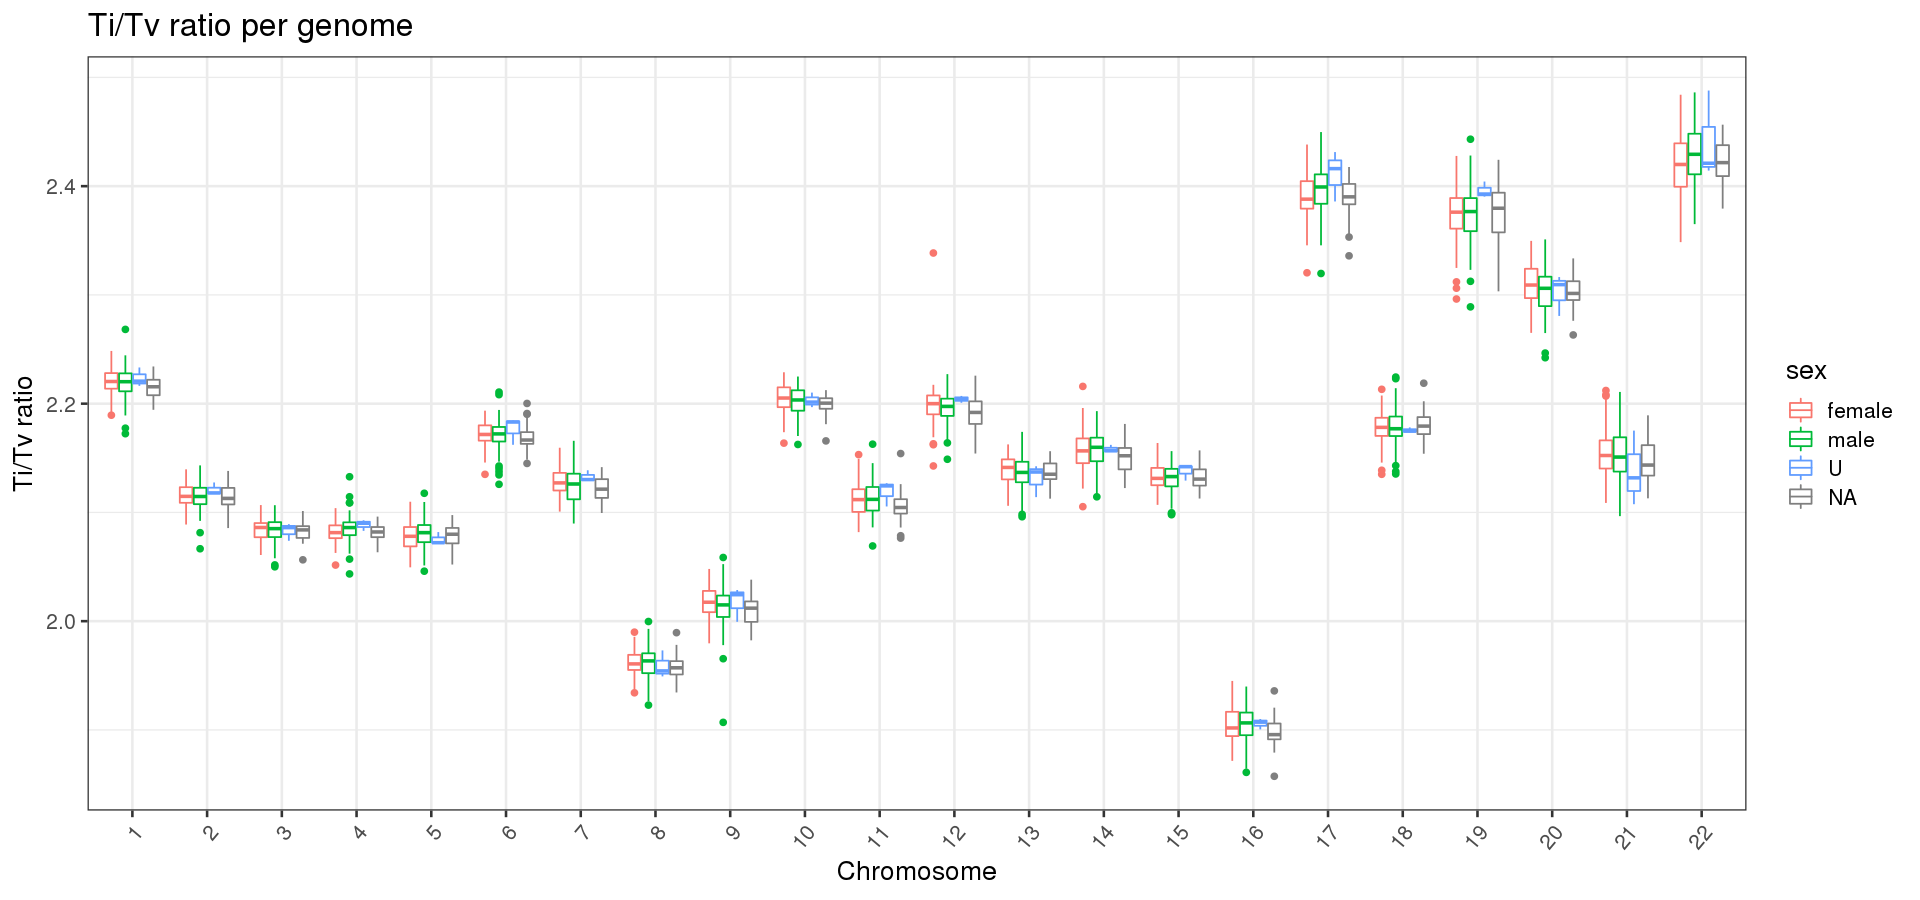

In [45]:
joined_chrom_results %>%
  filter(reference_name %in% c(AUTOSOMES)) %>%
  mutate(reference_name = parse_factor(reference_name, levels = c(AUTOSOMES))) %>%
  ggplot(aes(y = titv, x = reference_name, color = sex)) +
  geom_boxplot() +
  ylab('Ti/Tv ratio') +
  xlab('Chromosome') +
  ggtitle('Ti/Tv ratio per genome') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

## Display per-chromosome outliers 

In [46]:
titv_summary <- joined_chrom_results %>%
    group_by(reference_name) %>%
    summarize(
        titv_mean = mean(titv),
        titv_sd = sd(titv),
    )

head(titv_summary)

reference_name,titv_mean,titv_sd
<chr>,<dbl>,<dbl>
1,2.219252,0.01258482
10,2.202867,0.01241526
11,2.111731,0.01504897
12,2.196549,0.01564716
13,2.137940,0.01309361
14,2.157042,0.01730380


In [47]:
low_titv_sd_multiplier <- 4

(low_titv_outliers <- joined_chrom_results %>%
    inner_join(titv_summary) %>%
    filter(titv < titv_mean - (low_titv_sd_multiplier * titv_sd)) %>%
    arrange(reference_name, titv))

Joining, by = "reference_name"


name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,titv_mean,titv_sd
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
LP6005592-DNA_H03,2,206100,88676,206100,206100,0.43026,138892,67208,2.066599,Illumina,male,Oceania,2.115257,0.011184957
LP6005592-DNA_H03,4,186016,83410,186016,186016,0.44840,124896,61120,2.043455,Illumina,male,Oceania,2.083788,0.009898056
SS6004471,9,73619,26039,73619,73619,0.35370,48294,25325,1.906969,Illumina,male,Africa,2.014215,0.016098735
LP6005441-DNA_G10,X,51934,49354,51934,51934,0.95032,33785,18149,1.861535,Illumina,male,WestEurasia,2.054405,0.035042037
LP6005441-DNA_A10,X,55095,52322,55095,55095,0.94967,35945,19150,1.877023,Illumina,male,Oceania,2.054405,0.035042037
LP6005442-DNA_D01,X,50156,48158,50156,50156,0.96016,32779,17377,1.886344,Illumina,male,EastAsia,2.054405,0.035042037
LP6005592-DNA_H03,X,51989,49687,51989,51989,0.95572,34119,17870,1.909289,Illumina,male,Oceania,2.054405,0.035042037


In [48]:
high_titv_sd_multiplier <- 4

(high_titv_outliers <- joined_chrom_results %>%
    inner_join(titv_summary) %>%
    filter(titv > titv_mean + (high_titv_sd_multiplier * titv_sd)) %>%
    arrange(reference_name, desc(titv)))

Joining, by = "reference_name"


name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,titv_mean,titv_sd
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
LP6005443-DNA_G01,12,6440,3386,6440,6440,0.52578,4511,1929,2.338517,Illumina,female,EastAsia,2.196549,0.015647164
LP6005442-DNA_E04,4,181307,69166,181307,181307,0.38149,123433,57874,2.132788,Illumina,male,WestEurasia,2.083788,0.009898056


In [49]:
problems <- rbind(
    low_titv_outliers %>%
    group_by(name) %>%
    summarize(fail = str_glue('per chrom ti/tv is at least {low_titv_sd_multiplier} standard deviations below the mean for ',
                              str_c(reference_name, collapse = ','))),
    high_titv_outliers %>%
    group_by(name) %>%
    summarize(fail = str_glue('per chrom ti/tv is at least {high_titv_sd_multiplier} standard deviations above the mean for ',
                              str_c(reference_name, collapse = ','))),
    problems)

dim(problems)
head(problems)

[1] 39  2

name,fail
<chr>,<glue>
LP6005441-DNA_A10,per chrom ti/tv is at least 4 standard deviations below the mean for X
LP6005441-DNA_G10,per chrom ti/tv is at least 4 standard deviations below the mean for X
LP6005442-DNA_D01,per chrom ti/tv is at least 4 standard deviations below the mean for X
LP6005592-DNA_H03,"per chrom ti/tv is at least 4 standard deviations below the mean for 2,4,X"
SS6004471,per chrom ti/tv is at least 4 standard deviations below the mean for 9
LP6005442-DNA_E04,per chrom ti/tv is at least 4 standard deviations above the mean for 4


# Sex inference

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”

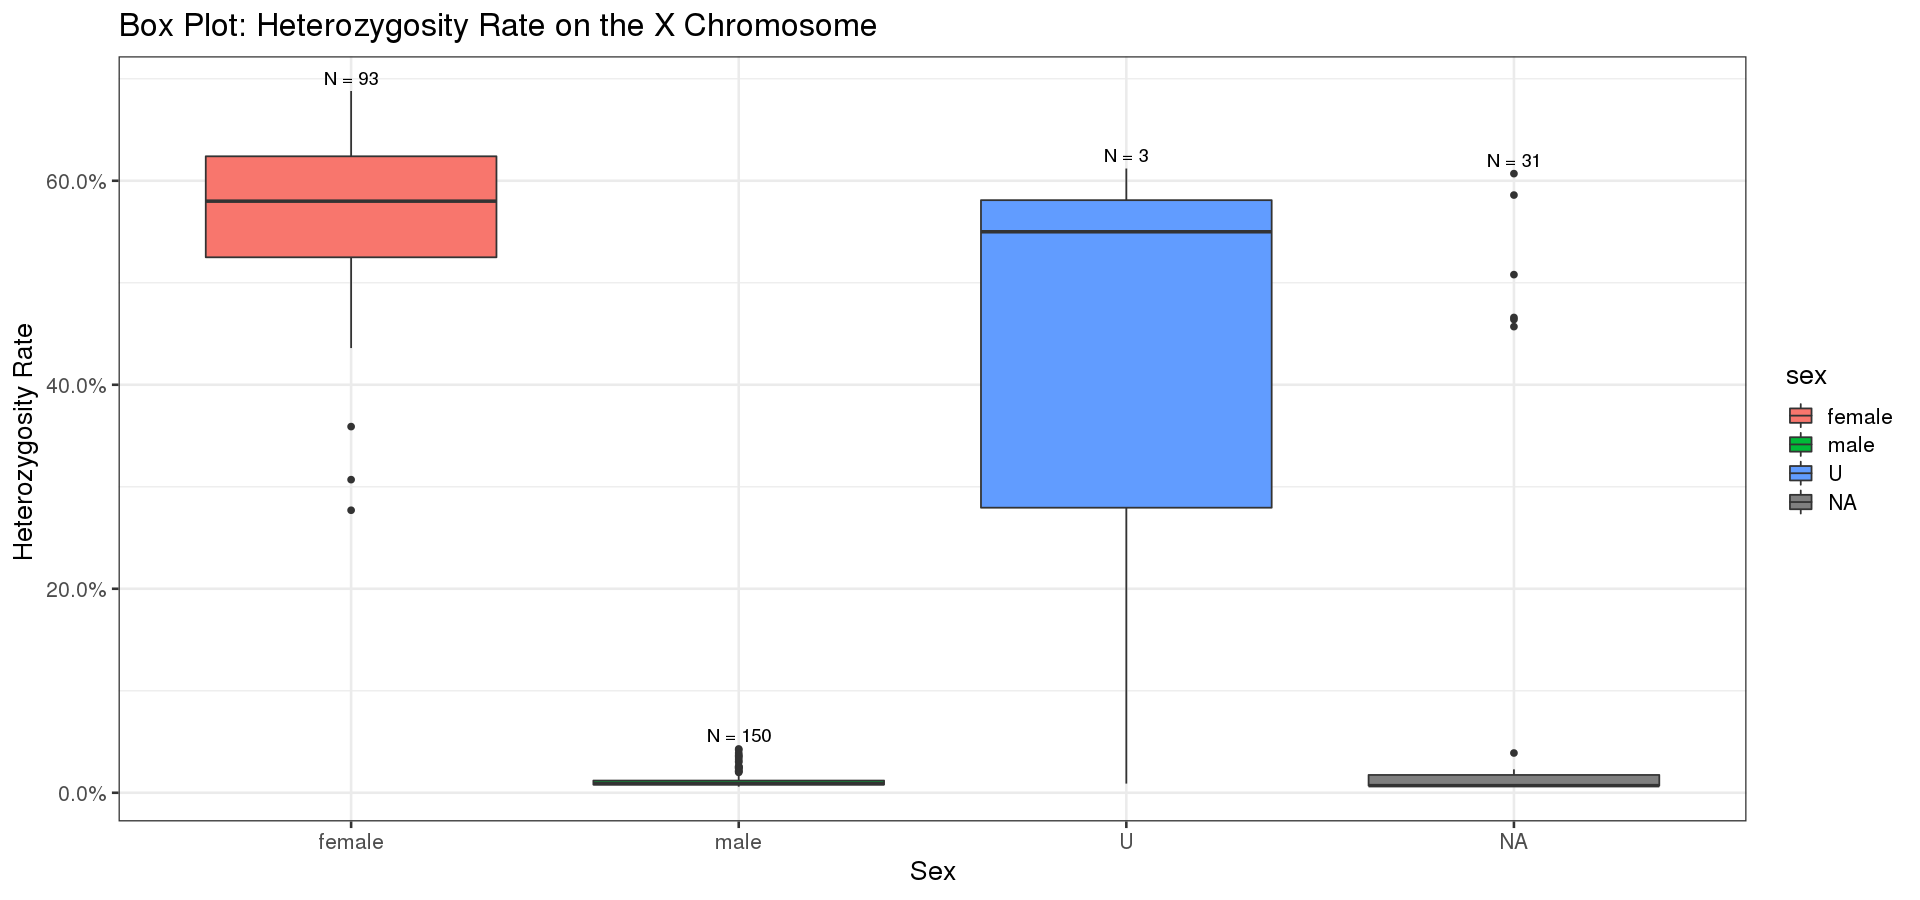

In [50]:
ggplot(joined_genome_results, aes(x = sex, y = perct_het_alt_in_snvs, fill = sex)) +
  geom_boxplot() +
  stat_summary(fun.data = get_boxplot_fun_data, geom = 'text', position = position_dodge(width = 0.9), vjust = -0.5) +
  scale_y_continuous(labels = percent_format()) +
  xlab('Sex') +
  ylab('Heterozygosity Rate ') +
  ggtitle('Box Plot: Heterozygosity Rate on the X Chromosome')

Warning message:
“Removed 2 rows containing missing values (geom_point).”

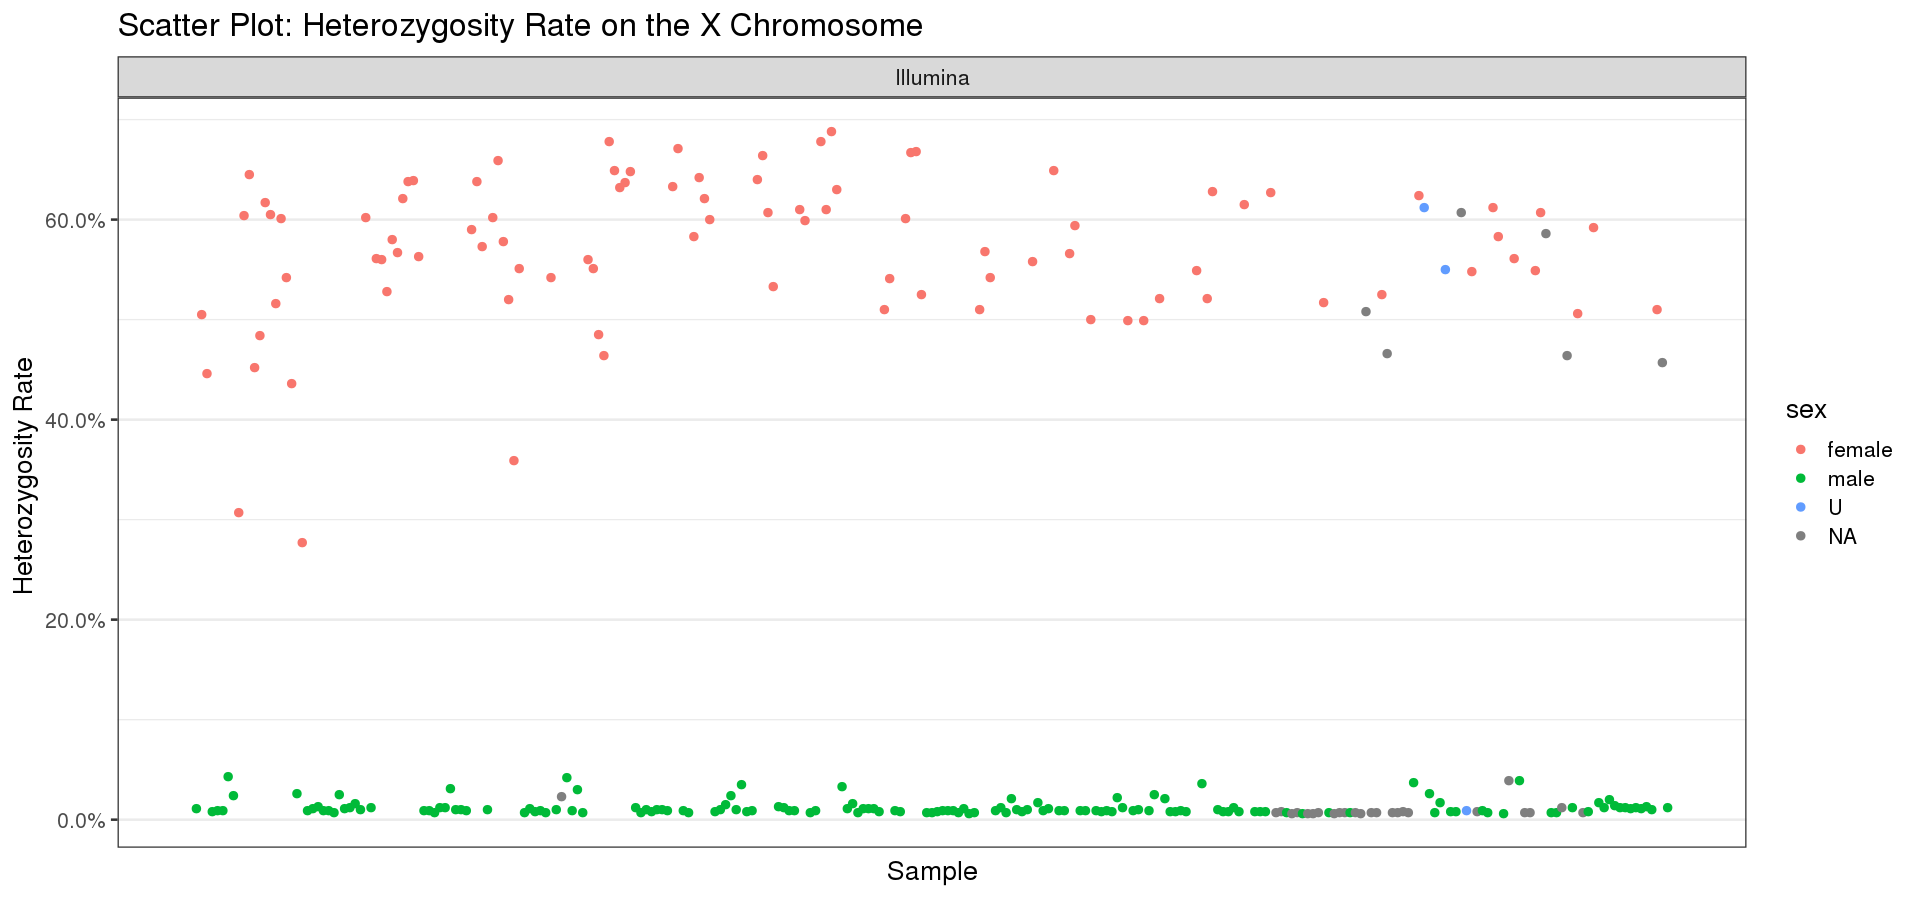

In [51]:
p <- ggplot(joined_genome_results) +
  geom_point(aes(x = name, y = perct_het_alt_in_snvs, color = sex)) +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(labels = percent_format()) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free') +
  xlab('Sample') +
  ylab('Heterozygosity Rate ') +
  ggtitle('Scatter Plot: Heterozygosity Rate on the X Chromosome')
if (nrow(joined_genome_results) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display outliers 

In [52]:
(m_outliers <- joined_genome_results %>%
    filter(!sex %in% c('F', 'FEMALE', 'female') & perct_het_alt_in_snvs > 0.4) %>%
    arrange(desc(perct_het_alt_in_snvs))
)

name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
LP6005592-DNA_B01,508980,4075598,0.1248847,29725,1586128,0.612,0.388,27275,43093,Illumina,U,WestEurasia
LP6005592-DNA_C05,723617,5364212,0.1348972,222136,2124679,0.607,0.393,48385,74738,Illumina,NA,Africa
LP6005677-DNA_B01,550627,4086208,0.1347526,33226,1544349,0.586,0.414,28956,40960,Illumina,NA,WestEurasia
LP6005592-DNA_C01,568630,4052343,0.1403213,25723,1496980,0.550,0.450,30240,36956,Illumina,U,WestEurasia
LP6005519-DNA_E06,572517,4049902,0.1413656,37932,1383080,0.508,0.492,33134,34166,Illumina,NA,Oceania
LP6005519-DNA_G02,566167,3949499,0.1433516,25800,1267478,0.466,0.534,36489,31894,Illumina,NA,America
LP6005677-DNA_D03,690484,5238023,0.1318215,223053,1952065,0.464,0.536,59261,51298,Illumina,NA,Africa
SS6004479,542368,3887179,0.1395274,26374,1243556,0.457,0.543,35051,29543,Illumina,NA,America


In [53]:
(f_outliers <- joined_genome_results %>%
    filter(! sex %in% c('M', 'MALE', 'male') & perct_het_alt_in_snvs < 0.4) %>%
    arrange(perct_het_alt_in_snvs))

name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
LP6005519-DNA_B04,566925,4142976,0.1368400,49311,1547285,0.006,0.994,53098,330,Illumina,NA,SouthAsia
LP6005519-DNA_C03,527577,4020038,0.1312368,33178,1416275,0.006,0.994,50180,319,Illumina,NA,WestEurasia
LP6005519-DNA_C04,560349,4121190,0.1359678,46710,1514947,0.006,0.994,52994,312,Illumina,NA,SouthAsia
LP6005519-DNA_D03,561514,4084245,0.1374829,33580,1531195,0.006,0.994,49785,303,Illumina,NA,WestEurasia
LP6005519-DNA_E05,568875,4137079,0.1375064,57928,1508017,0.006,0.994,52651,337,Illumina,NA,SouthAsia
LP6005519-DNA_A04,575193,4156124,0.1383965,47842,1557311,0.007,0.993,54123,376,Illumina,NA,SouthAsia
LP6005519-DNA_B05,548318,4096440,0.1338523,45282,1468958,0.007,0.993,51976,350,Illumina,NA,SouthAsia
LP6005519-DNA_C05,570679,4144529,0.1376945,49762,1542317,0.007,0.993,51461,348,Illumina,NA,SouthAsia
LP6005519-DNA_D04,579675,4148704,0.1397244,47187,1538168,0.007,0.993,50708,348,Illumina,NA,SouthAsia


In [54]:
problems <- rbind(
    tibble(name = m_outliers$name, fail = str_glue('sample info indicates {m_outliers$sex}, genome indicates female')),
    tibble(name = f_outliers$name, fail = str_glue('sample info indicates {f_outliers$sex}, genome indicates male')),
    problems)

dim(problems)
head(problems)

[1] 76  2

name,fail
<chr>,<glue>
LP6005592-DNA_B01,"sample info indicates U, genome indicates female"
LP6005592-DNA_C05,"sample info indicates NA, genome indicates female"
LP6005677-DNA_B01,"sample info indicates NA, genome indicates female"
LP6005592-DNA_C01,"sample info indicates U, genome indicates female"
LP6005519-DNA_E06,"sample info indicates NA, genome indicates female"
LP6005519-DNA_G02,"sample info indicates NA, genome indicates female"


# Problem summary

Group all the 'problems' together by sample and emit a CSV report.

In [55]:
(problem_summary <- problems %>%
    group_by(name) %>%
    summarize(
        issues = str_c(fail, collapse = ';\n '),
        issue_count = n()
    ) %>%
    arrange(desc(issue_count), name))

name,issues,issue_count
<chr>,<chr>,<int>
LP6005441-DNA_A12,"sample info indicates female, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 13,19,5",2
LP6005441-DNA_B12,"sample info indicates female, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 10",2
LP6005441-DNA_F10,"sample info indicates female, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 19",2
LP6005441-DNA_G09,"sample info indicates NA, genome indicates male; per chrom variant count is at least 3 standard deviations below the platform mean for X",2
LP6005443-DNA_D09,heterozygous variant count at least 3 standard deviations below the ancestry and platform mean; heterozygous variant count at least 3 standard deviations above the ancestry and platform mean,2
LP6005443-DNA_G01,per chrom ti/tv is at least 4 standard deviations above the mean for 12; per chrom variant count is at least 3 standard deviations below the platform mean for 12,2
LP6005519-DNA_B05,"sample info indicates NA, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 14",2
LP6005519-DNA_C03,"sample info indicates NA, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 20",2
LP6005592-DNA_G03,"sample info indicates NA, genome indicates male; per chrom homozygosity is at least 4 standard deviations below the mean Y",2


In [56]:
write_csv(problem_summary, path = 'problem_summary.csv')

# Provenance 

In [57]:
devtools::session_info()

─ Session info ───────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Debian GNU/Linux 9 (stretch)
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2019-12-03                  

─ Packages ───────────────────────────────────────────────────────────────────
 package     * version date       lib source        
 assertthat    0.2.1   2019-03-21 [2] CRAN (R 3.6.1)
 backports     1.1.4   2019-04-10 [2] CRAN (R 3.6.1)
 base64enc     0.1-3   2015-07-28 [2] CRAN (R 3.6.1)
 bigrquery   * 1.2.0   2019-07-02 [1] CRAN (R 3.6.1)
 bit           1.1-14  2018-05-29 [2] CRAN (R 3.6.1)
 bit64         0.9-7   2017-05-08 [2] CRAN (R 3.6.1)
 broom         0.5.2   2019-04-07 [1] CRAN (R 3.6.1)
 callr         3.3.2   2019

Copyright 2019 Verily Life Sciences LLC. All rights reserved.

Licensed under the Apache License, Version 2.0 (the 'License');
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an 'AS IS' BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.